In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pycountry
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from focal_loss import BinaryFocalLoss
from sklearn.metrics import recall_score, precision_score
from tensorflow.keras import metrics
from sklearn.utils.class_weight import compute_sample_weight


## Load Data

In [443]:
dfolder = 'data/'

In [444]:
df_final = pd.read_csv(dfolder + 'preprocessed_df.csv')

## Preprocessing

In [445]:
df_final['country'] = df_final['Country Name']

In [446]:
df_final['armedconf'] = df_final['armedconf'].astype(int)
df_final['civilwar'] = df_final['civilwar'].astype(int)
df_final = df_final[df_final['year'] >= 2000]


## Normalizing

Here i'm taking the top 10 countries for model intereprestability later

In [447]:
armedconfdf = df_final.drop(columns=['isocode','civilwar','Country Name', 'MonthYear', 'date', 'state_deaths','nonstate_deaths','onesided_deaths','civilian_deaths', 'deaths_all_pc', 'deaths_state_pc'])

In [448]:
armedconfdf.columns

Index(['month', 'year', 'deaths', 'month_year', 'wb_pop', 'total_events',
       'total_events_gov', 'total_events_opp', 'share_events_count_events_1',
       'share_events_count_events_2', 'share_events_count_events_3',
       'share_events_count_events_4', 'share_events_count_events_5',
       'share_events_count_events_6', 'share_events_count_events_7',
       'share_events_count_events_8', 'share_events_count_events_9',
       'share_events_count_events_10', 'share_events_count_events_11',
       'share_events_count_events_12', 'share_events_count_events_13',
       'share_events_count_events_14', 'share_events_count_events_15',
       'share_events_count_events_16', 'share_events_count_events_17',
       'share_events_count_events_18', 'share_events_count_events_19',
       'share_events_count_events_20', 'share_events_count_events_1_gov',
       'share_events_count_events_2_gov', 'share_events_count_events_3_gov',
       'share_events_count_events_4_gov', 'share_events_count_even

In [449]:
top_10_countries=pd.DataFrame(armedconfdf.groupby('country')['armedconf'].sum()).sort_values(by='armedconf',ascending=False).reset_index()
top_10_country_names=top_10_countries.country[:11]

In [450]:
# normalized the data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_final.drop(columns=['isocode','month','year','civilwar','armedconf','Country Name', 'MonthYear', 'month_year', 'date', 'country']))

In [451]:
scaled_df=pd.DataFrame(data=scaled,columns=df_final.drop(columns=['isocode','month','year','civilwar','armedconf','Country Name', 'MonthYear', 'month_year', 'date', 'country']).columns)


In [452]:
scaled_df

,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,wb_pop,total_events,total_events_gov,total_events_opp,share_events_count_events_1,...,deaths_state_pc,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median
0,0.002054,0.002117,0.0,0.000000,0.001888,0.013818,0.001234,0.001357,0.001280,0.114855,...,0.004603,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220
1,0.001370,0.000000,0.0,0.012312,0.002614,0.011588,0.001280,0.001977,0.002246,0.131365,...,0.003658,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612
2,0.000000,0.000000,0.0,0.000000,0.000000,0.002168,0.001282,0.001844,0.001721,0.108656,...,0.000000,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020
3,0.000000,0.000000,0.0,0.000000,0.000000,0.002299,0.000231,0.000314,0.000126,0.110429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004
4,0.000000,0.000000,0.0,0.000000,0.000000,0.026228,0.000579,0.001005,0.000567,0.118174,...,0.000000,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54742,0.000000,0.000000,0.0,0.000000,0.000000,0.001245,0.000153,0.000177,0.000063,0.092308,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000
54743,0.000000,0.000000,0.0,0.000000,0.000000,0.023333,0.000793,0.000970,0.000987,0.082192,...,0.000000,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971
54744,0.000000,0.000000,0.0,0.000000,0.000000,0.042033,0.010216,0.010367,0.002666,0.151882,...,0.000000,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530
54745,0.000000,0.000000,0.0,0.000000,0.000000,0.013768,0.000620,0.000917,0.000042,0.146992,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.624697,0.042918,0.000046,0.000034,0.000033


In [453]:
conf=df_final.copy()
conf[scaled_df.columns]=np.array(scaled_df)
conf['country']=list(conf.country)
conf=conf.set_index(['isocode','month','year'])
conf

,,,MonthYear,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,Country Name,wb_pop,date,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,month,year,,,,,,,,,,,,,,,,,,,,,
AFG,1,2000,1970-01-01 00:00:00.000200001,0.002054,0.002117,0.0,0.000000,0.001888,2000-01-01,Afghanistan,0.013818,2000-01-01,...,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220,Afghanistan
AGO,1,2000,1970-01-01 00:00:00.000200001,0.001370,0.000000,0.0,0.012312,0.002614,2000-01-01,Angola,0.011588,2000-01-01,...,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612,Angola
ALB,1,2000,1970-01-01 00:00:00.000200001,0.000000,0.000000,0.0,0.000000,0.000000,2000-01-01,Albania,0.002168,2000-01-01,...,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020,Albania
ARE,1,2000,1970-01-01 00:00:00.000200001,0.000000,0.000000,0.0,0.000000,0.000000,2000-01-01,United Arab Emirates,0.002299,2000-01-01,...,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004,United Arab Emirates
ARG,1,2000,1970-01-01 00:00:00.000200001,0.000000,0.000000,0.0,0.000000,0.000000,2000-01-01,Argentina,0.026228,2000-01-01,...,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,5,2023,1970-01-01 00:00:00.000202305,0.000000,0.000000,0.0,0.000000,0.000000,2023-05-01,Kosovo,0.001245,2023-05-01,...,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000,Kosovo
YEM,5,2023,1970-01-01 00:00:00.000202305,0.000000,0.000000,0.0,0.000000,0.000000,2023-05-01,"Yemen, Rep.",0.023333,2023-05-01,...,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971,"Yemen, Rep."
ZAF,5,2023,1970-01-01 00:00:00.000202305,0.000000,0.000000,0.0,0.000000,0.000000,2023-05-01,South Africa,0.042033,2023-05-01,...,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530,South Africa


In [454]:
top_10_country_names

0                  Afghanistan
1                      Somalia
2                         Iraq
3                        Sudan
4             Congo, Dem. Rep.
5     Central African Republic
6                      Nigeria
7                       Israel
8                  Yemen, Rep.
9         Syrian Arab Republic
10                      Mexico
Name: country, dtype: object

In [455]:
conf.drop(['civilwar', 'Country Name', 'MonthYear', 'month_year', 'date', 'state_deaths','nonstate_deaths','onesided_deaths','civilian_deaths'], axis=1, inplace=True)


In [456]:
conf

,,,deaths,wb_pop,total_events,total_events_gov,total_events_opp,share_events_count_events_1,share_events_count_events_2,share_events_count_events_3,share_events_count_events_4,share_events_count_events_5,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,month,year,,,,,,,,,,,,,,,,,,,,,
AFG,1,2000,0.002054,0.013818,0.001234,0.001357,0.001280,0.114855,0.045559,0.072741,0.346861,0.089969,...,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220,Afghanistan
AGO,1,2000,0.001370,0.011588,0.001280,0.001977,0.002246,0.131365,0.042804,0.085240,0.254982,0.052768,...,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612,Angola
ALB,1,2000,0.000000,0.002168,0.001282,0.001844,0.001721,0.108656,0.046041,0.081400,0.275875,0.060037,...,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020,Albania
ARE,1,2000,0.000000,0.002299,0.000231,0.000314,0.000126,0.110429,0.026585,0.065440,0.533742,0.051125,...,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004,United Arab Emirates
ARG,1,2000,0.000000,0.026228,0.000579,0.001005,0.000567,0.118174,0.053790,0.114914,0.418093,0.060310,...,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,5,2023,0.000000,0.001245,0.000153,0.000177,0.000063,0.092308,0.076923,0.089231,0.307692,0.190769,...,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000,Kosovo
YEM,5,2023,0.000000,0.023333,0.000793,0.000970,0.000987,0.082192,0.046456,0.054199,0.406194,0.107802,...,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971,"Yemen, Rep."
ZAF,5,2023,0.000000,0.042033,0.010216,0.010367,0.002666,0.151882,0.068819,0.066460,0.250162,0.075432,...,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530,South Africa


### Train Test Split

In [457]:
def train_test_split(data):
    size=int(len(data)*0.8)
    # for train data will be collected from each country's data which index is from 0-size (80%)
    x_train =data.drop(columns=['armedconf']).iloc[0:size] 
    # for test data will be collected from each country's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['armedconf']).iloc[size:]
    y_train=data['armedconf'].iloc[0:size] 
    y_test=data['armedconf'].iloc[size:] 
    return x_train, x_test,y_train,y_test

In [458]:
country=list(set(conf.country))
# loop each station and collect train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=conf[conf['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split(data)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [459]:
# concat each train data from each station 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concat each test data from each station º
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

In [460]:
X_train

deaths    wb_pop  total_events  total_events_gov  \
isocode month year                                                     
MYS     1     2000     0.0  0.016227      0.000948          0.001341   
        2     2000     0.0  0.016227      0.000627          0.000883   
        3     2000     0.0  0.016227      0.000982          0.001825   
        4     2000     0.0  0.016227      0.001559          0.002585   
        5     2000     0.0  0.016227      0.001778          0.002413   
...                    ...       ...           ...               ...   
GAB     4     2018     0.0  0.001532      0.000365          0.000332   
        5     2018     0.0  0.001532      0.000176          0.000177   
        6     2018     0.0  0.001532      0.000171          0.000114   
        7     2018     0.0  0.001532      0.000144          0.000147   
        8     2018     0.0  0.001532      0.000230          0.000131   

                    total_events_opp  share_events_count_events_1  \
isocode month year                                                  
MYS     1     2000          0.001092                     0.166418   
        2     2000          0.000399                     0.185994   
        3     2000          0.000861                     0.195767   
        4     2000          0.001889                     0.170606   
        5     2000          0.003820                     0.135530   
...                              ...                          ...   
GAB     4     2018          0.000042                     0.091850   
        5     2018          0.000105                     0.085561   
        6     2018          0.000021                     0.085399   
        7     2018          0.000021                     0.094771   
        8     2018          0.000084                     0.135246   

                    share_events_count_events_2  share_events_count_events_3  \
isocode month year                                                             
MYS     1     2000                     0.079223                     0.064275   
        2     2000                     0.098645                     0.082831   
        3     2000                     0.089466                     0.089466   
        4     2000                     0.039697                     0.063333   
        5     2000                     0.061121                     0.079458   
...                                         ...                          ...   
GAB     4     2018                     0.126779                     0.081501   
        5     2018                     0.106952                     0.037433   
        6     2018                     0.057851                     0.107438   
        7     2018                     0.055556                     0.205882   
        8     2018                     0.047131                     0.024590   

                    share_events_count_events_4  share_events_count_events_5  \
isocode month year                                                             
MYS     1     2000                     0.265072                     0.055805   
        2     2000                     0.213102                     0.070783   
        3     2000                     0.248677                     0.042809   
        4     2000                     0.283636                     0.059394   
        5     2000                     0.294446                     0.060324   
...                                         ...                          ...   
GAB     4     2018                     0.382924                     0.077620   
        5     2018                     0.227273                     0.219251   
        6     2018                     0.349862                     0.143251   
        7     2018                     0.261438                     0.078431   
        8     2018                     0.303279                     0.243852   

                    ...  past6  past12  past60  past120  armedconf_since  \
isocode month year  ...    

In [461]:
X_test

deaths    wb_pop  total_events  total_events_gov  \
isocode month year                                                     
MYS     9     2018     0.0  0.022921      0.014381          0.019692   
        10    2018     0.0  0.022921      0.014985          0.020793   
        11    2018     0.0  0.022921      0.014860          0.020611   
        12    2018     0.0  0.022921      0.012536          0.016739   
        1     2019     0.0  0.023207      0.011782          0.016272   
...                    ...       ...           ...               ...   
GAB     1     2023     0.0  0.001638      0.000372          0.000458   
        2     2023     0.0  0.001638      0.000258          0.000290   
        3     2023     0.0  0.001638      0.000356          0.000354   
        4     2023     0.0  0.001638      0.000300          0.000319   
        5     2023     0.0  0.001638      0.000097          0.000085   

                    total_events_opp  share_events_count_events_1  \
isocode month year                                                  
MYS     9     2018          0.006801                     0.155474   
        10    2018          0.005395                     0.159226   
        11    2018          0.006612                     0.166100   
        12    2018          0.005647                     0.160787   
        1     2019          0.003191                     0.156073   
...                              ...                          ...   
GAB     1     2023          0.000000                     0.090102   
        2     2023          0.000042                     0.073126   
        3     2023          0.000147                     0.117881   
        4     2023          0.000252                     0.077044   
        5     2023          0.000000                     0.135922   

                    share_events_count_events_2  share_events_count_events_3  \
isocode month year                                                             
MYS     9     2018                     0.082928                     0.064562   
        10    2018                     0.089702                     0.078825   
        11    2018                     0.085085                     0.071317   
        12    2018                     0.094904                     0.073119   
        1     2019                     0.083530                     0.071540   
...                                         ...                          ...   
GAB     1     2023                     0.035533                     0.237310   
        2     2023                     0.062157                     0.177331   
        3     2023                     0.046358                     0.156291   
        4     2023                     0.044025                     0.081761   
        5     2023                     0.053398                     0.082524   

                    share_events_count_events_4  share_events_count_events_5  \
isocode month year                                                             
MYS     9     2018                     0.233145                     0.075700   
        10    2018                     0.224745                     0.070627   
        11    2018                     0.230962                     0.080315   
        12    2018                     0.200249                     0.085406   
        1     2019                     0.256326                     0.079601   
...                                         ...                          ...   
GAB     1     2023                     0.474619                     0.050761   
        2     2023                     0.458867                     0.047532   
        3     2023                     0.487417                     0.054305   
        4     2023                     0.331761                     0.246855   
        5     2023                     0.252427                     0.150485   

                    ...  past6  past12  past60   past120  armedconf_since  \
isocode month year  ...   

## Model

In [462]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t+1, t+2, ... t+n)
    for i in range(1, n_out+1):
        cols.append(df.shift(-i))
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    reframed_train
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train, y_test, reframed_train

In [463]:
encoder = LabelEncoder()
#combine x train and y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
#combine x test and y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])
test_data.shape

(11098, 99)

In [464]:
train_data

deaths    wb_pop  total_events  total_events_gov  \
isocode month year                                                     
MYS     1     2000     0.0  0.016227      0.000948          0.001341   
        2     2000     0.0  0.016227      0.000627          0.000883   
        3     2000     0.0  0.016227      0.000982          0.001825   
        4     2000     0.0  0.016227      0.001559          0.002585   
        5     2000     0.0  0.016227      0.001778          0.002413   
...                    ...       ...           ...               ...   
GAB     4     2018     0.0  0.001532      0.000365          0.000332   
        5     2018     0.0  0.001532      0.000176          0.000177   
        6     2018     0.0  0.001532      0.000171          0.000114   
        7     2018     0.0  0.001532      0.000144          0.000147   
        8     2018     0.0  0.001532      0.000230          0.000131   

                    total_events_opp  share_events_count_events_1  \
isocode month year                                                  
MYS     1     2000          0.001092                     0.166418   
        2     2000          0.000399                     0.185994   
        3     2000          0.000861                     0.195767   
        4     2000          0.001889                     0.170606   
        5     2000          0.003820                     0.135530   
...                              ...                          ...   
GAB     4     2018          0.000042                     0.091850   
        5     2018          0.000105                     0.085561   
        6     2018          0.000021                     0.085399   
        7     2018          0.000021                     0.094771   
        8     2018          0.000084                     0.135246   

                    share_events_count_events_2  share_events_count_events_3  \
isocode month year                                                             
MYS     1     2000                     0.079223                     0.064275   
        2     2000                     0.098645                     0.082831   
        3     2000                     0.089466                     0.089466   
        4     2000                     0.039697                     0.063333   
        5     2000                     0.061121                     0.079458   
...                                         ...                          ...   
GAB     4     2018                     0.126779                     0.081501   
        5     2018                     0.106952                     0.037433   
        6     2018                     0.057851                     0.107438   
        7     2018                     0.055556                     0.205882   
        8     2018                     0.047131                     0.024590   

                    share_events_count_events_4  share_events_count_events_5  \
isocode month year                                                             
MYS     1     2000                     0.265072                     0.055805   
        2     2000                     0.213102                     0.070783   
        3     2000                     0.248677                     0.042809   
        4     2000                     0.283636                     0.059394   
        5     2000                     0.294446                     0.060324   
...                                         ...                          ...   
GAB     4     2018                     0.382924                     0.077620   
        5     2018                     0.227273                     0.219251   
        6     2018                     0.349862                     0.143251   
        7     2018                     0.261438                     0.078431   
        8     2018                     0.303279                     0.243852   

                    ...  past12  past60  past120  armedconf_since  \
isocode month year  ...           

In [465]:
x_train,x_test,y_train,y_test,example =reshape_data(train_data,test_data)

In [466]:
example

(11096, 1, 197)

In [474]:
x_test.shape

(11096, 1, 197)

In [467]:
x_train.shape

(43647, 1, 197)

In [468]:
# Compute class weights
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

class_weights = dict(enumerate(class_weights))

# design network for confirmed cases data 
model = Sequential()
model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2])))  # Single LSTM layer with 60 neurons
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Output layer

loss = BinaryFocalLoss(gamma=2., pos_weight=3)  # Increase gamma for more focus on hard to classify instances
model.compile(loss=loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy', metrics.Recall()])

# fit network with class weights for handling imbalance
history = model.fit(x_train, y_train, epochs=30, batch_size=50, class_weight=class_weights, verbose=1, shuffle=False)


Epoch 1/30


2023-06-22 20:57:23.969215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 20:57:24.421292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 20:57:27.001630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


873/873 [==============================] - 19s 17ms/step - loss: 0.0890 - accuracy: 0.9032 - recall_65: 0.0610
Epoch 2/30
873/873 [==============================] - 11s 12ms/step - loss: 0.0782 - accuracy: 0.8909 - recall_65: 0.1279
Epoch 3/30
873/873 [==============================] - 11s 13ms/step - loss: 0.0697 - accuracy: 0.9043 - recall_65: 0.2053
Epoch 4/30
873/873 [==============================] - 12s 14ms/step - loss: 0.0582 - accuracy: 0.9109 - recall_65: 0.4316
Epoch 5/30
873/873 [==============================] - 12s 13ms/step - loss: 0.0454 - accuracy: 0.9232 - recall_65: 0.5601
Epoch 6/30
873/873 [==============================] - 11s 13ms/step - loss: 0.0405 - accuracy: 0.9256 - recall_65: 0.6711
Epoch 7/30
873/873 [==============================] - 11s 13ms/step - loss: 0.0368 - accuracy: 0.9305 - recall_65: 0.7329
Epoch 8/30
873/873 [==============================] - 12s 13ms/step - loss: 0.0372 - accuracy: 0.9305 - recall_65: 0.7248
Epoch 9/30
873/873 [===============

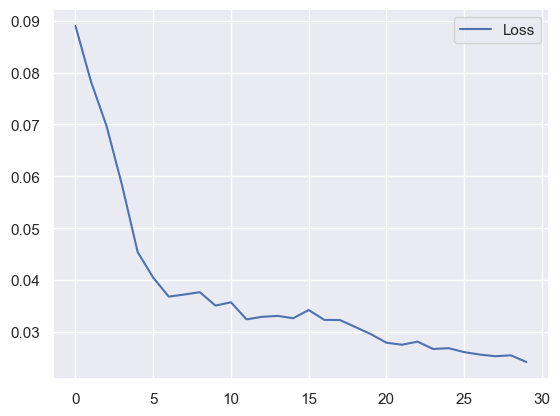

In [469]:
# plot history
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [470]:
y_hat = model.predict(x_test)

2023-06-22 21:03:02.831822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:03:02.894483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - 2s 4ms/step


In [471]:
y_hat.shape,y_test.shape


((11096, 1), (11096,))

In [472]:
#  y_test prediction has one month lag so we need re-match the date 
len([i[0] for i in y_hat][1:]),len(y_test[:-1])  


(11095, 11095)

In [479]:
y_hat_modified = [i[0] for i in y_hat][2:]  # discarding the first two elements
y_test_modified = y_test[:-2]  # discarding the last two elements

print(len(y_hat_modified), len(y_test_modified))  # check if lengths are now the same

pa = pd.DataFrame()
pa['Month'] = X_test.reset_index().month.iloc[2:-2]  # also adjusted here
pa['Year'] = X_test.reset_index().year.iloc[2:-2]  # and here
pa['Prediction'] = y_hat_modified
pa['Actual Values'] = y_test_modified
pa.head()


11094 11094


,Month,Year,Prediction,Actual Values
2,11,2018,0.075688,0.0
3,12,2018,0.083078,0.0
4,1,2019,0.067754,0.0
5,2,2019,0.066227,0.0
6,3,2019,0.060592,0.0


In [480]:
pa['Actual Values'].sum()

1122.0

## Interpretation

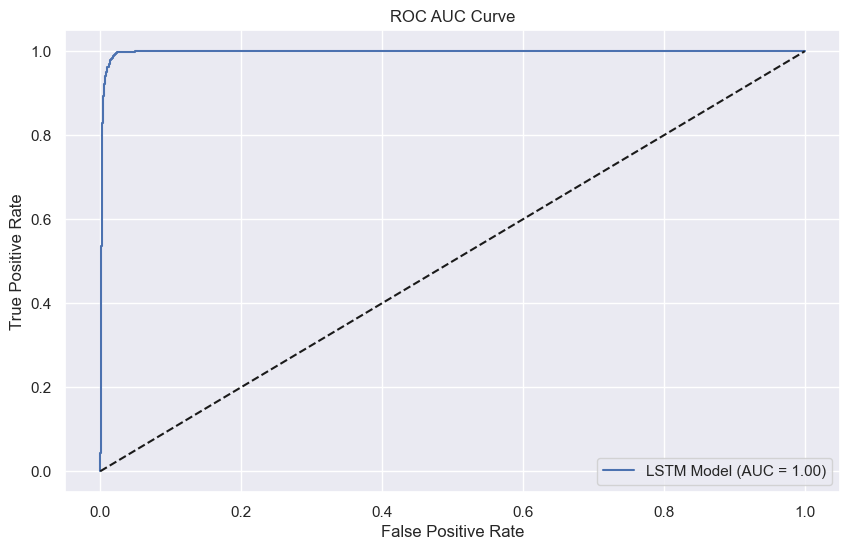

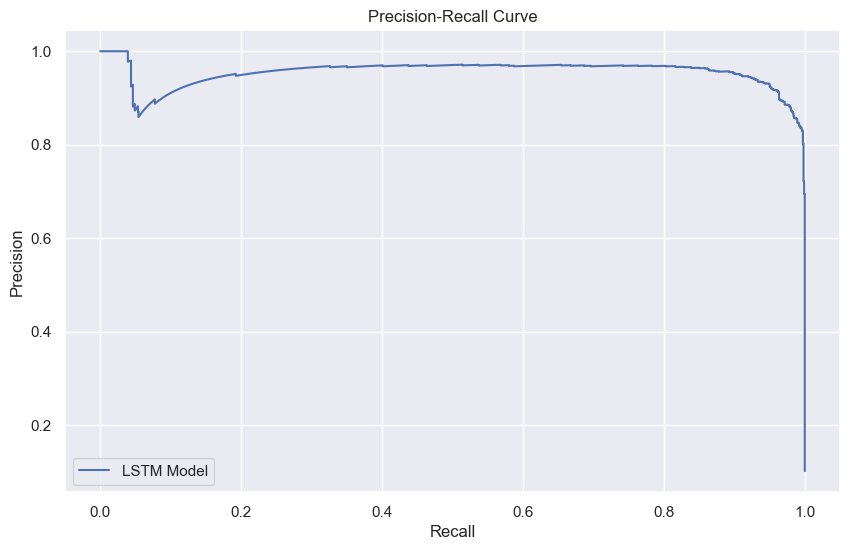

In [481]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc


y_true = pa['Actual Values'].values
y_pred = pa['Prediction'].values


# Calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred)

# Calculate Precision and Recall scores
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Plot ROC AUC curve
plt.figure(figsize=(10, 6))
plt.plot(*roc_curve(y_true, y_pred)[:2], label='LSTM Model (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='LSTM Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [ ]:
thresholds

array([3.5470593e-04, 3.5550247e-04, 3.5569063e-04, ..., 9.9909687e-01,
       9.9921513e-01, 9.9923003e-01], dtype=float32)

In [482]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# classes
y_pred_classes = (pa['Prediction'].values > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(pa['Actual Values'].values, y_pred_classes))

print("\nClassification Report:\n", classification_report(pa['Actual Values'].values, y_pred_classes))

roc_auc_minority = roc_auc_score(pa['Actual Values'].values == 1, y_pred_classes)
print("\nROC AUC for minority class:", roc_auc_minority)

Confusion Matrix:
 [[9719  253]
 [   3 1119]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      9972
         1.0       0.82      1.00      0.90      1122

    accuracy                           0.98     11094
   macro avg       0.91      0.99      0.94     11094
weighted avg       0.98      0.98      0.98     11094


ROC AUC for minority class: 0.9859775821498055


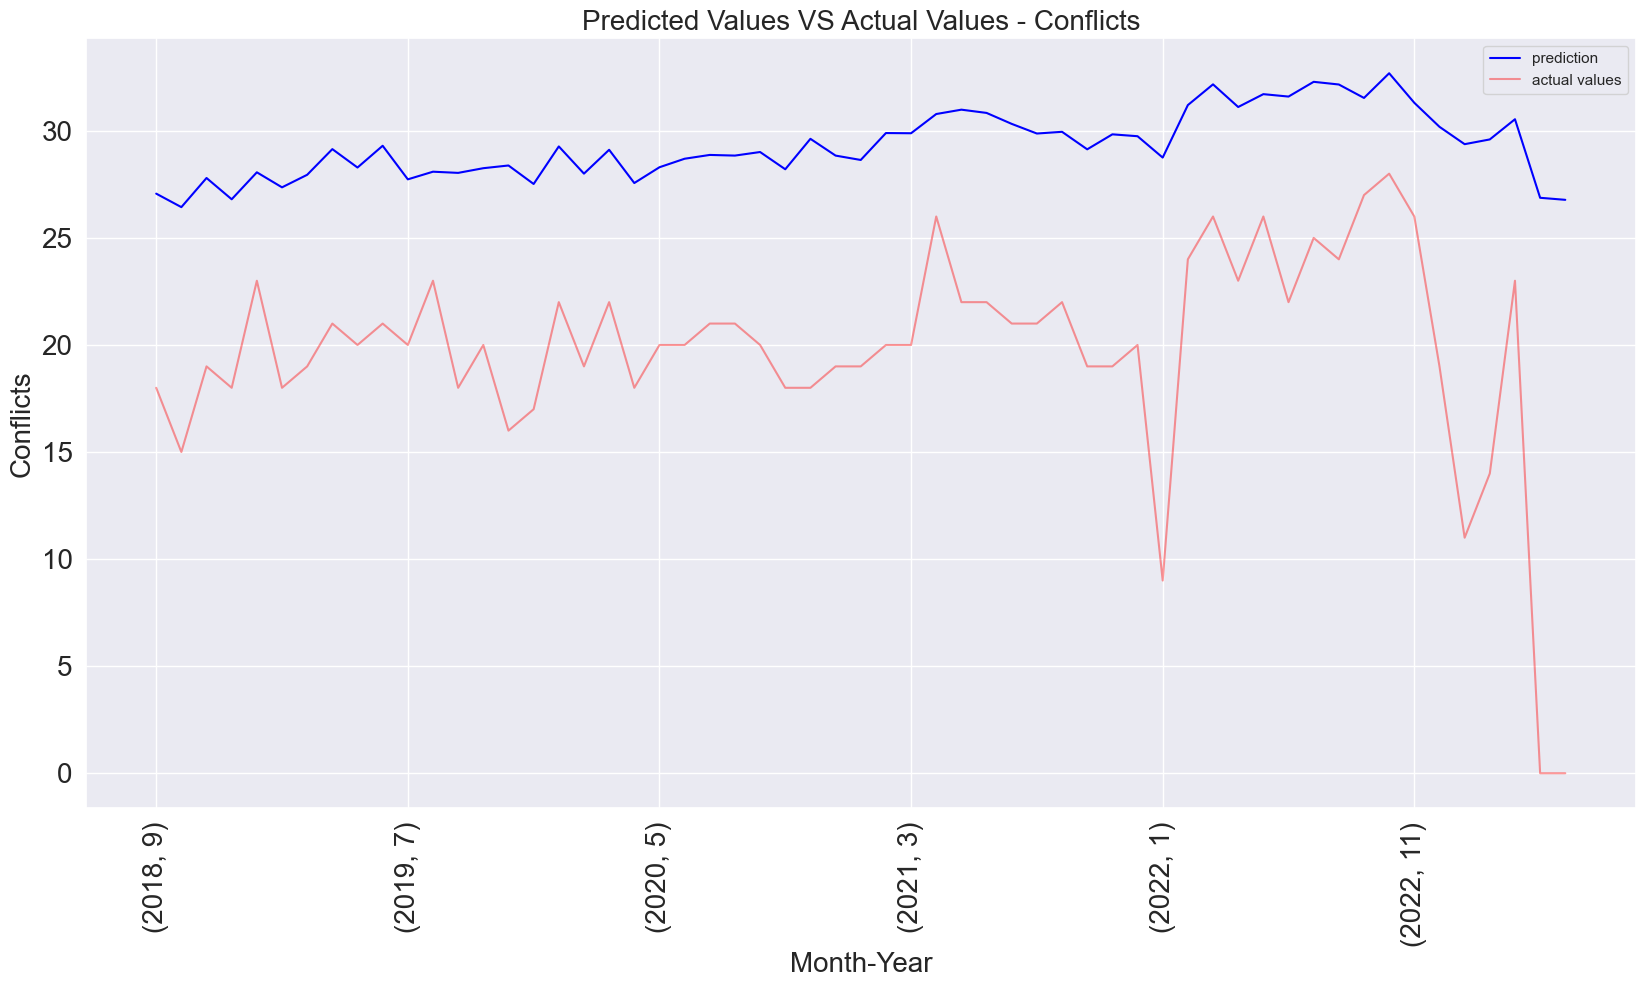

In [483]:
plt.figure(figsize=(20,10))
pa.groupby(['Year', 'Month'])['Prediction'].sum().plot(kind='line', label='prediction', color='blue', alpha=1)
pa.groupby(['Year', 'Month'])['Actual Values'].sum().plot(kind='line', label='actual values', color='red', alpha=0.4)
plt.xticks(rotation=90, size=20)
plt.yticks(size=20)

plt.ylabel('Conflicts', fontsize=20)
plt.xlabel('Month-Year', fontsize=20)
plt.title('Predicted Values VS Actual Values - Conflicts', fontsize=20)
plt.legend()


In [484]:
conf.columns

Index(['deaths', 'wb_pop', 'total_events', 'total_events_gov',
       'total_events_opp', 'share_events_count_events_1',
       'share_events_count_events_2', 'share_events_count_events_3',
       'share_events_count_events_4', 'share_events_count_events_5',
       'share_events_count_events_6', 'share_events_count_events_7',
       'share_events_count_events_8', 'share_events_count_events_9',
       'share_events_count_events_10', 'share_events_count_events_11',
       'share_events_count_events_12', 'share_events_count_events_13',
       'share_events_count_events_14', 'share_events_count_events_15',
       'share_events_count_events_16', 'share_events_count_events_17',
       'share_events_count_events_18', 'share_events_count_events_19',
       'share_events_count_events_20', 'share_events_count_events_1_gov',
       'share_events_count_events_2_gov', 'share_events_count_events_3_gov',
       'share_events_count_events_4_gov', 'share_events_count_events_5_gov',
       'share_events

In [485]:
df_final.month_year

25128    2000-01-01
25129    2000-01-01
25130    2000-01-01
25131    2000-01-01
25132    2000-01-01
            ...    
79870    2023-05-01
79871    2023-05-01
79872    2023-05-01
79873    2023-05-01
79874    2023-05-01
Name: month_year, Length: 54747, dtype: object

In [486]:
conf

,,,deaths,wb_pop,total_events,total_events_gov,total_events_opp,share_events_count_events_1,share_events_count_events_2,share_events_count_events_3,share_events_count_events_4,share_events_count_events_5,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,month,year,,,,,,,,,,,,,,,,,,,,,
AFG,1,2000,0.002054,0.013818,0.001234,0.001357,0.001280,0.114855,0.045559,0.072741,0.346861,0.089969,...,0.088991,0.031529,0.146054,0.042366,0.000000,0.133047,0.241271,0.304625,0.316220,Afghanistan
AGO,1,2000,0.001370,0.011588,0.001280,0.001977,0.002246,0.131365,0.042804,0.085240,0.254982,0.052768,...,0.031879,0.023356,0.022099,0.022688,0.000000,0.081545,0.072586,0.066002,0.070612,Angola
ALB,1,2000,0.000000,0.002168,0.001282,0.001844,0.001721,0.108656,0.046041,0.081400,0.275875,0.060037,...,0.000000,0.000265,0.000156,0.000024,0.021792,0.055794,0.000023,0.000021,0.000020,Albania
ARE,1,2000,0.000000,0.002299,0.000231,0.000314,0.000126,0.110429,0.026585,0.065440,0.533742,0.051125,...,0.000000,0.000000,0.000000,0.000000,0.322034,0.030043,0.000005,0.000004,0.000004,United Arab Emirates
ARG,1,2000,0.000000,0.026228,0.000579,0.001005,0.000567,0.118174,0.053790,0.114914,0.418093,0.060310,...,0.000000,0.000000,0.000000,0.000030,0.159806,0.077253,0.000589,0.000155,0.000068,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,5,2023,0.000000,0.001245,0.000153,0.000177,0.000063,0.092308,0.076923,0.089231,0.307692,0.190769,...,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000,Kosovo
YEM,5,2023,0.000000,0.023333,0.000793,0.000970,0.000987,0.082192,0.046456,0.054199,0.406194,0.107802,...,0.004942,0.003316,0.082242,0.019899,0.004843,0.081545,0.076791,0.063539,0.064971,"Yemen, Rep."
ZAF,5,2023,0.000000,0.042033,0.010216,0.010367,0.002666,0.151882,0.068819,0.066460,0.250162,0.075432,...,0.000000,0.000014,0.000083,0.000013,0.053269,0.042918,0.005656,0.006331,0.007530,South Africa


In [487]:
df_final

,MonthYear,isocode,month,year,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
25128,1970-01-01 00:00:00.000200001,AFG,1,2000,54.0,54.0,0.0,0.0,26.0,2000-01-01,...,16.706907,22.972855,180.652765,346.465884,0,32,629.252033,582.202685,578.869009,Afghanistan
25129,1970-01-01 00:00:00.000200001,AGO,1,2000,36.0,0.0,0.0,36.0,36.0,2000-01-01,...,5.984914,17.017786,27.334553,185.535914,0,20,189.309091,126.144306,129.261468,Angola
25130,1970-01-01 00:00:00.000200001,ALB,1,2000,0.0,0.0,0.0,0.0,0.0,2000-01-01,...,0.000000,0.193002,0.193002,0.193002,9,14,0.060606,0.039237,0.036156,Albania
25131,1970-01-01 00:00:00.000200001,ARE,1,2000,0.0,0.0,0.0,0.0,0.0,2000-01-01,...,0.000000,0.000000,0.000000,0.000000,133,8,0.012346,0.007773,0.007618,United Arab Emirates
25132,1970-01-01 00:00:00.000200001,ARG,1,2000,0.0,0.0,0.0,0.0,0.0,2000-01-01,...,0.000000,0.000000,0.000000,0.249357,66,19,1.535714,0.295357,0.125364,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79870,1970-01-01 00:00:00.000202305,XKX,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,0.000000,0.000000,0.000000,0.000000,412,10,0.000000,0.000000,0.000000,Kosovo
79871,1970-01-01 00:00:00.000202305,YEM,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,0.927789,2.416496,101.723726,162.727194,2,20,200.276596,121.436293,118.934417,"Yemen, Rep."
79872,1970-01-01 00:00:00.000202305,ZAF,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,0.000000,0.010102,0.102890,0.108207,22,11,14.751497,12.100576,13.784257,South Africa
79873,1970-01-01 00:00:00.000202305,ZMB,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,0.000000,0.000000,0.000000,0.000000,258,11,0.120482,0.065602,0.060748,Zambia


In [488]:
df_final.set_index(['isocode', 'month', 'year'], inplace=True)


In [489]:
country

['Malaysia',
 'Lesotho',
 'Paraguay',
 'Antigua and Barbuda',
 'Belarus',
 'Djibouti',
 'North Macedonia',
 'Sweden',
 'Cyprus',
 'Congo, Rep.',
 'Chad',
 'Macao SAR, China',
 'Mexico',
 'Korea, Rep.',
 'Bangladesh',
 'Georgia',
 'Sudan',
 'Serbia',
 'Oman',
 'Tanzania',
 'Grenada',
 'Mauritius',
 'South Africa',
 'South Sudan',
 'Nepal',
 'Cuba',
 'Hong Kong SAR, China',
 'Armenia',
 'Lithuania',
 'Morocco',
 'Guinea-Bissau',
 'Ecuador',
 'Honduras',
 'Dominica',
 'Timor-Leste',
 'Estonia',
 'Eritrea',
 'Bahrain',
 'El Salvador',
 'Portugal',
 'Belize',
 'Mauritania',
 'Cambodia',
 'Botswana',
 'Bulgaria',
 'Gibraltar',
 'Sao Tome and Principe',
 'Algeria',
 'Sierra Leone',
 'Monaco',
 'Solomon Islands',
 'Eswatini',
 'Suriname',
 'Finland',
 'Croatia',
 'Seychelles',
 'Kosovo',
 'Bosnia and Herzegovina',
 'Iraq',
 'Ethiopia',
 'Kyrgyz Republic',
 'Singapore',
 'Turkmenistan',
 'Romania',
 'Gambia, The',
 'Russian Federation',
 'Rwanda',
 'Denmark',
 'Peru',
 'Uzbekistan',
 'Japan',
 

In [490]:
def normalization_train_test_split(country):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(country.drop(columns=['armedconf','country','month_year']))
    # create datefrane fir scaled data
    scaled_df=pd.DataFrame(data=scaled,columns=country.drop(columns=['armedconf','country','month_year']).columns)
    scaled_df['armedconf']=list(country.armedconf)
    X_train, X_test,Y_train,Y_test=train_test_split(scaled_df)
    #combine x train and y train as train data 
    train_data=pd.DataFrame()
    train_data[X_train.columns]=X_train
    train_data['armedconf']=Y_train
    #combine x test and y test as test data 
    test_data=pd.DataFrame()
    test_data[X_test.columns]=X_test
    test_data['armedconf']=Y_test

    # using the function to obtian reshaped x_train,x_test,y_train,y_test
    x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)
    return x_train, x_test,y_train,y_test

In [491]:
armedconfdf.to_csv('armedconfdf.csv')

Epoch 1/30


2023-06-22 21:11:47.567090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:11:47.974919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:11:49.472400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 5s 414ms/step - loss: 0.1568 - accuracy: 0.9414 - recall_68: 0.9498
Epoch 2/30
5/5 [==============================] - 1s 169ms/step - loss: 0.0413 - accuracy: 0.9865 - recall_68: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 97ms/step - loss: 0.0169 - accuracy: 0.9865 - recall_68: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 93ms/step - loss: 0.0132 - accuracy: 0.9865 - recall_68: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 51ms/step - loss: 0.0133 - accuracy: 0.9865 - recall_68: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 32ms/step - loss: 0.0137 - accuracy: 0.9865 - recall_68: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 52ms/step - loss: 0.0140 - accuracy: 0.9865 - recall_68: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 33ms/step - loss: 0.0139 - accuracy: 0.9865 - recall_68: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 58ms/step - loss: 0.

2023-06-22 21:11:57.106665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:11:57.162783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 101ms/step
Afghanistan - Precision: 0.9245283018867925


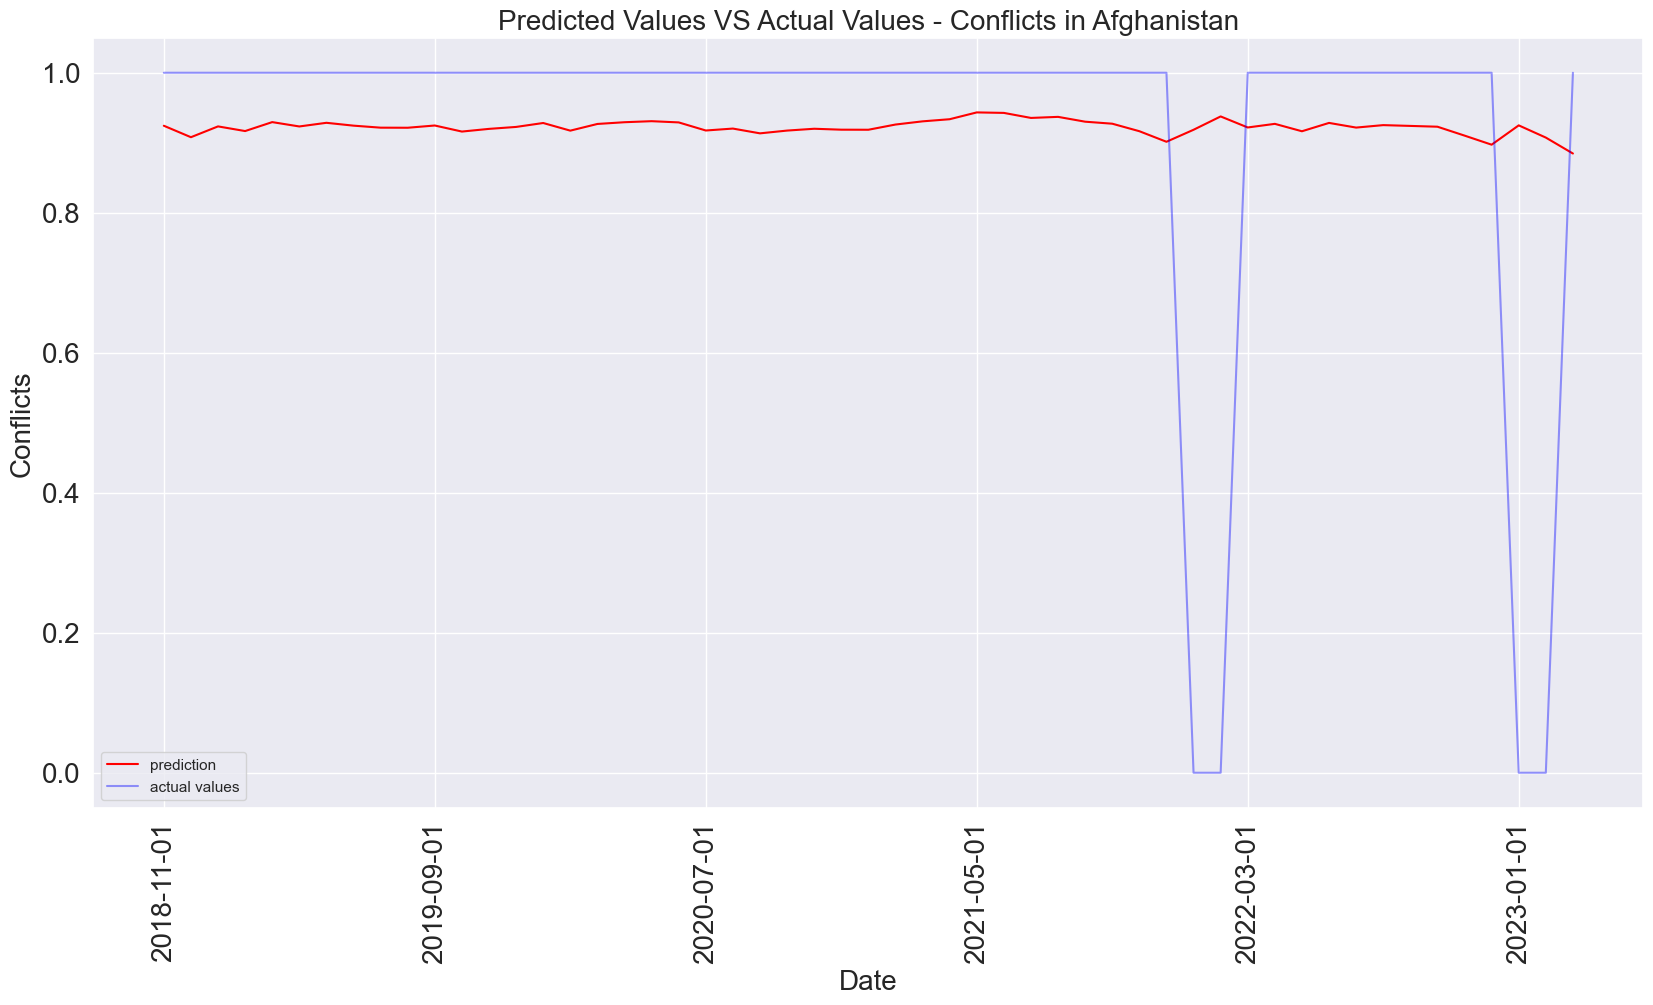

Epoch 1/30


2023-06-22 21:11:58.375953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:11:58.687315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:11:59.860213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 4s 470ms/step - loss: 1.9739 - accuracy: 0.8604 - recall_69: 0.9314
Epoch 2/30
5/5 [==============================] - 1s 153ms/step - loss: 0.7564 - accuracy: 0.9189 - recall_69: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 140ms/step - loss: 0.5573 - accuracy: 0.9189 - recall_69: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 98ms/step - loss: 0.5903 - accuracy: 0.9189 - recall_69: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 21ms/step - loss: 0.6258 - accuracy: 0.9189 - recall_69: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 32ms/step - loss: 0.6252 - accuracy: 0.9189 - recall_69: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 59ms/step - loss: 0.5997 - accuracy: 0.9189 - recall_69: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 31ms/step - loss: 0.5662 - accuracy: 0.9189 - recall_69: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 39ms/step - loss: 0

2023-06-22 21:12:07.003582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:07.055562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 77ms/step
Somalia - Precision: 0.9811320754716981


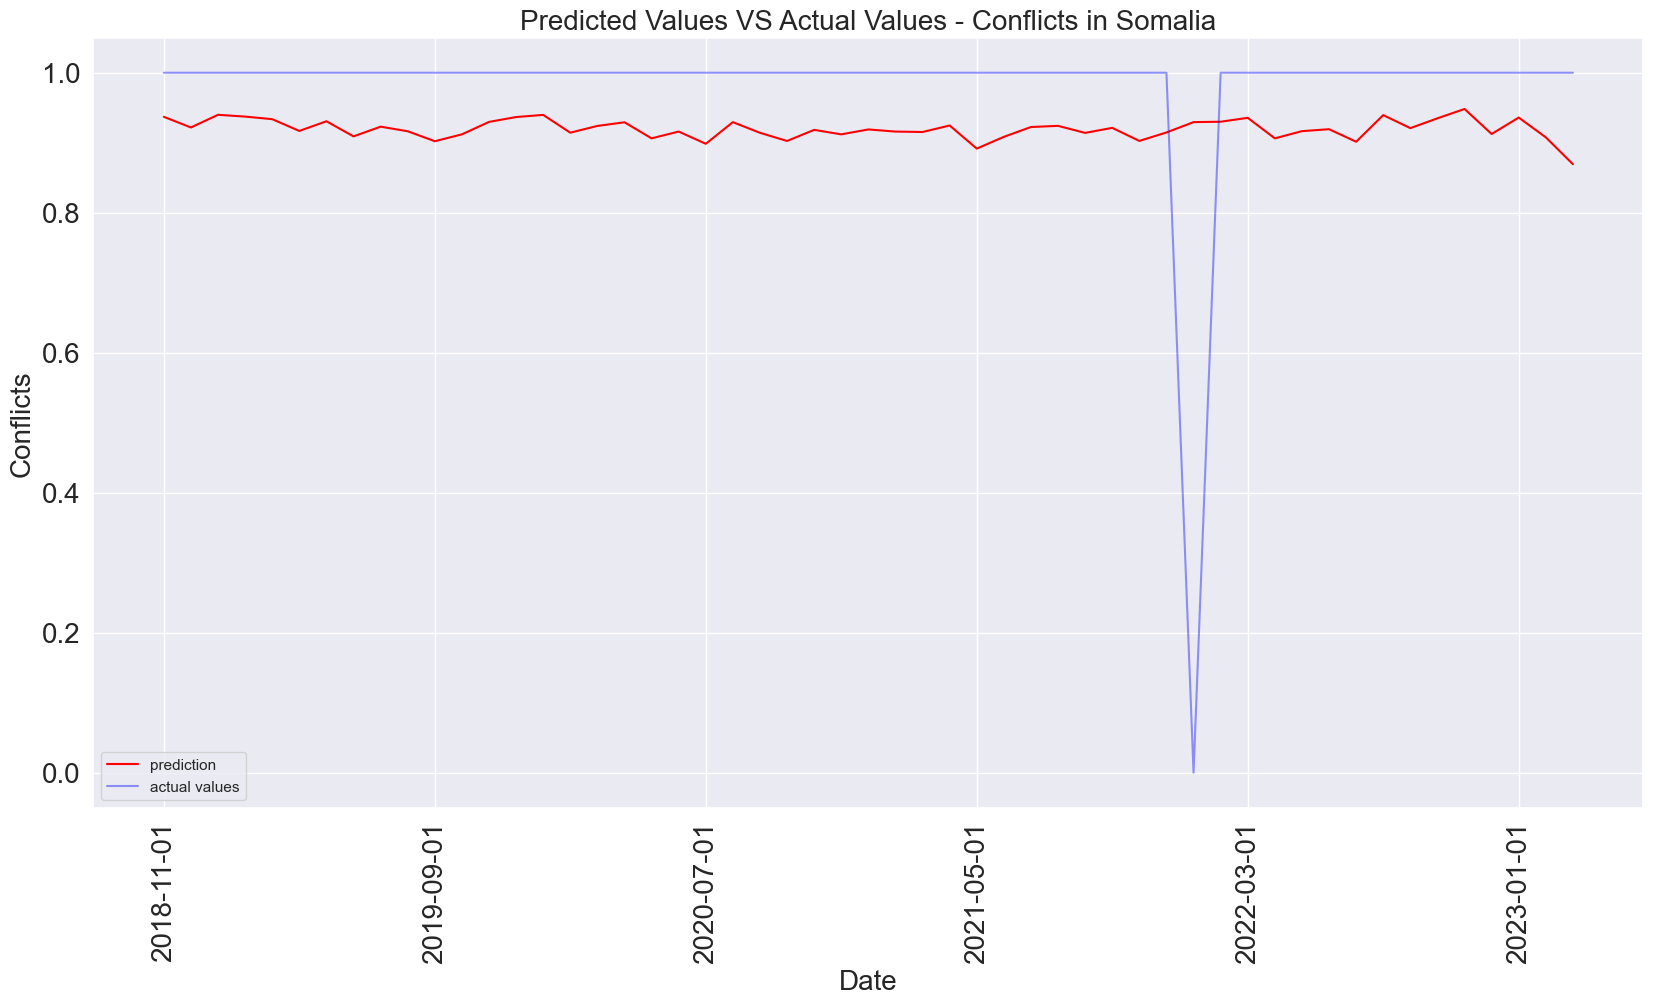

Epoch 1/30


2023-06-22 21:12:08.214202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:08.480668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:09.800009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 5s 445ms/step - loss: 0.9606 - accuracy: 0.8378 - recall_70: 0.8462
Epoch 2/30
5/5 [==============================] - 1s 188ms/step - loss: 0.4198 - accuracy: 0.8198 - recall_70: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 172ms/step - loss: 0.3616 - accuracy: 0.8198 - recall_70: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 50ms/step - loss: 0.3912 - accuracy: 0.8198 - recall_70: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 80ms/step - loss: 0.3943 - accuracy: 0.8198 - recall_70: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 40ms/step - loss: 0.3679 - accuracy: 0.8198 - recall_70: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 71ms/step - loss: 0.3296 - accuracy: 0.8198 - recall_70: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 19ms/step - loss: 0.2925 - accuracy: 0.8198 - recall_70: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 26ms/step - loss: 0

2023-06-22 21:12:17.646606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:17.702692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 74ms/step
Iraq - Precision: 0.9433962264150944


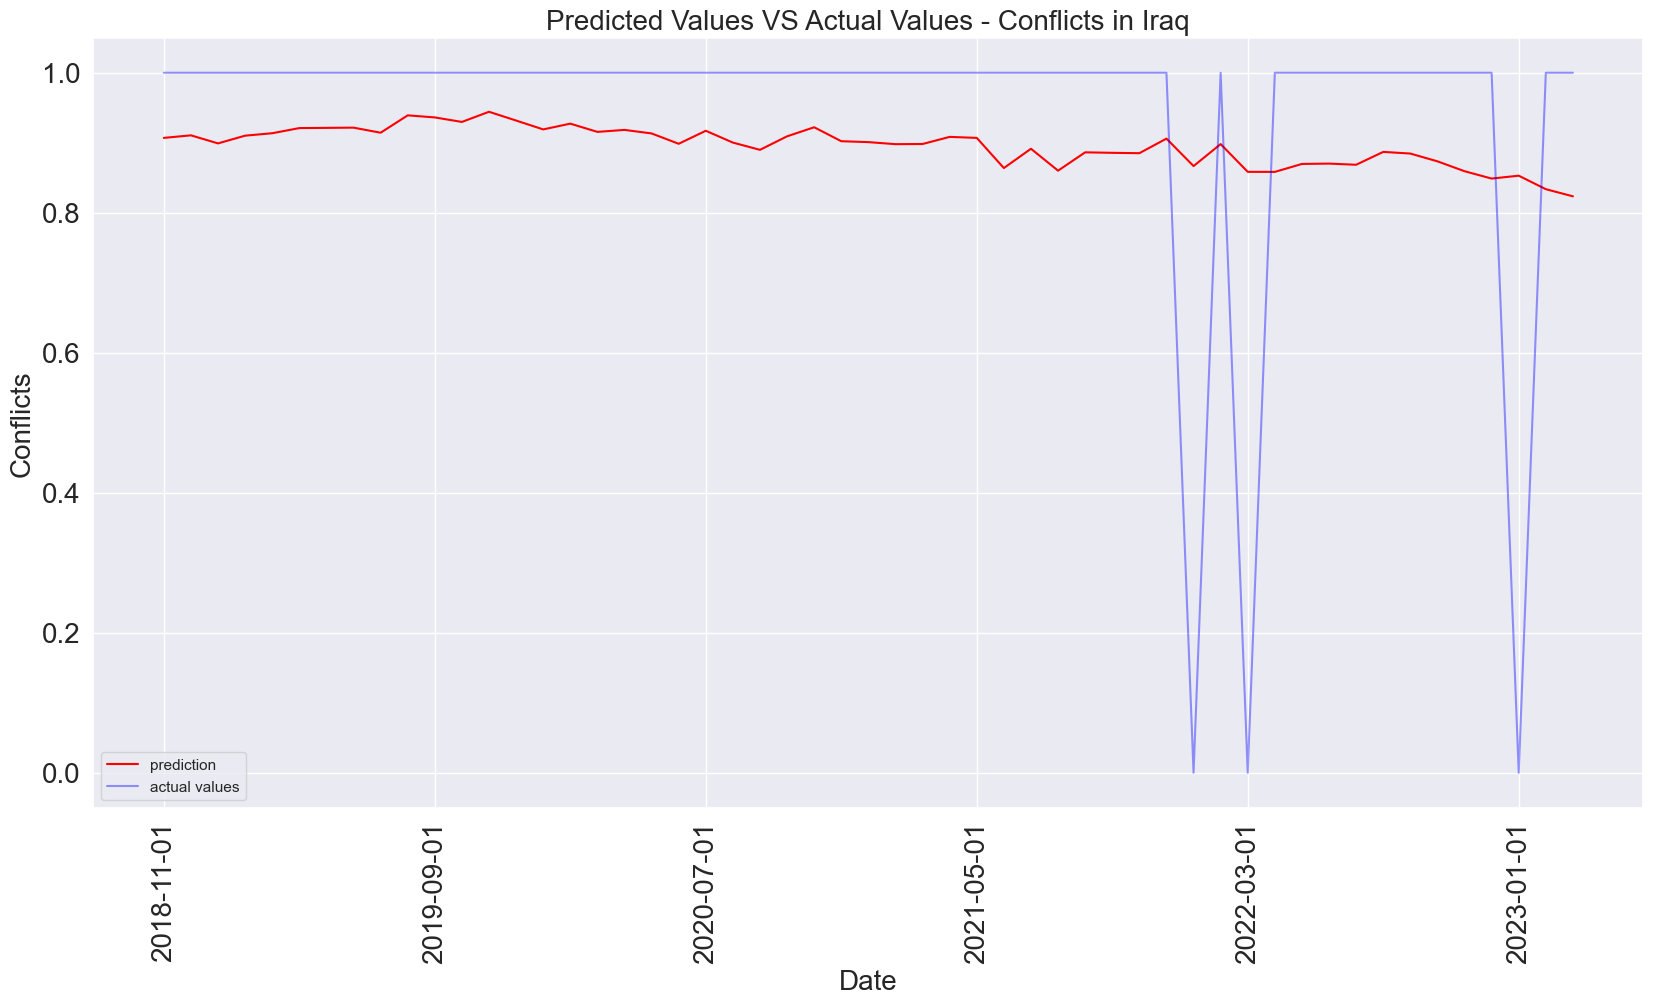

Epoch 1/30


2023-06-22 21:12:18.844251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:19.093975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:20.346437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 5s 514ms/step - loss: 0.1910 - accuracy: 0.8018 - recall_71: 0.9153
Epoch 2/30
5/5 [==============================] - 1s 221ms/step - loss: 0.1022 - accuracy: 0.8514 - recall_71: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 99ms/step - loss: 0.0977 - accuracy: 0.8514 - recall_71: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 64ms/step - loss: 0.0981 - accuracy: 0.8514 - recall_71: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 197ms/step - loss: 0.0945 - accuracy: 0.8514 - recall_71: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 15ms/step - loss: 0.0921 - accuracy: 0.8514 - recall_71: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 38ms/step - loss: 0.0925 - accuracy: 0.8514 - recall_71: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 74ms/step - loss: 0.0930 - accuracy: 0.8514 - recall_71: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 14ms/step - loss: 0

2023-06-22 21:12:28.730238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:28.782487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 81ms/step
Sudan - Precision: 0.5882352941176471


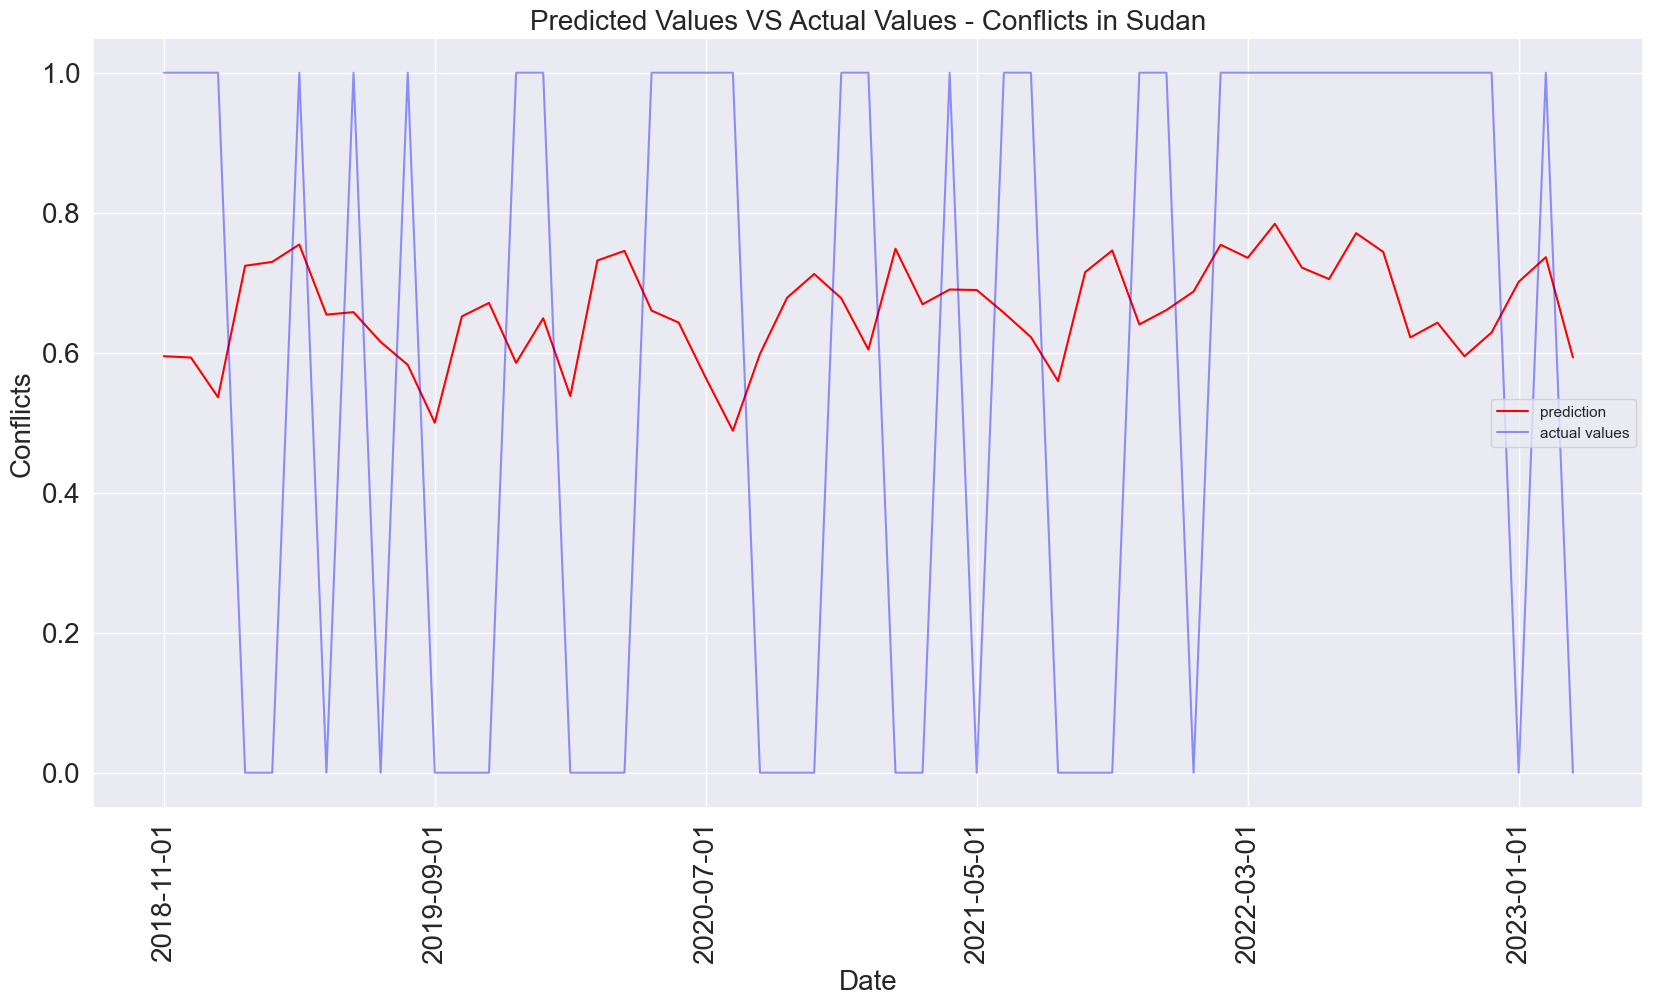

Epoch 1/30


2023-06-22 21:12:31.760723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:32.113928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:33.453115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 7s 511ms/step - loss: 0.2303 - accuracy: 0.6396 - recall_72: 0.8500
Epoch 2/30
5/5 [==============================] - 1s 173ms/step - loss: 0.1603 - accuracy: 0.7207 - recall_72: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 102ms/step - loss: 0.1668 - accuracy: 0.7207 - recall_72: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 63ms/step - loss: 0.1709 - accuracy: 0.7207 - recall_72: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 50ms/step - loss: 0.1637 - accuracy: 0.7207 - recall_72: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 39ms/step - loss: 0.1554 - accuracy: 0.7207 - recall_72: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 14ms/step - loss: 0.1507 - accuracy: 0.7207 - recall_72: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 19ms/step - loss: 0.1480 - accuracy: 0.7207 - recall_72: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 55ms/step - loss: 0

2023-06-22 21:12:41.321924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:41.374080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 39ms/step
Congo, Dem. Rep. - Precision: 0.9622641509433962


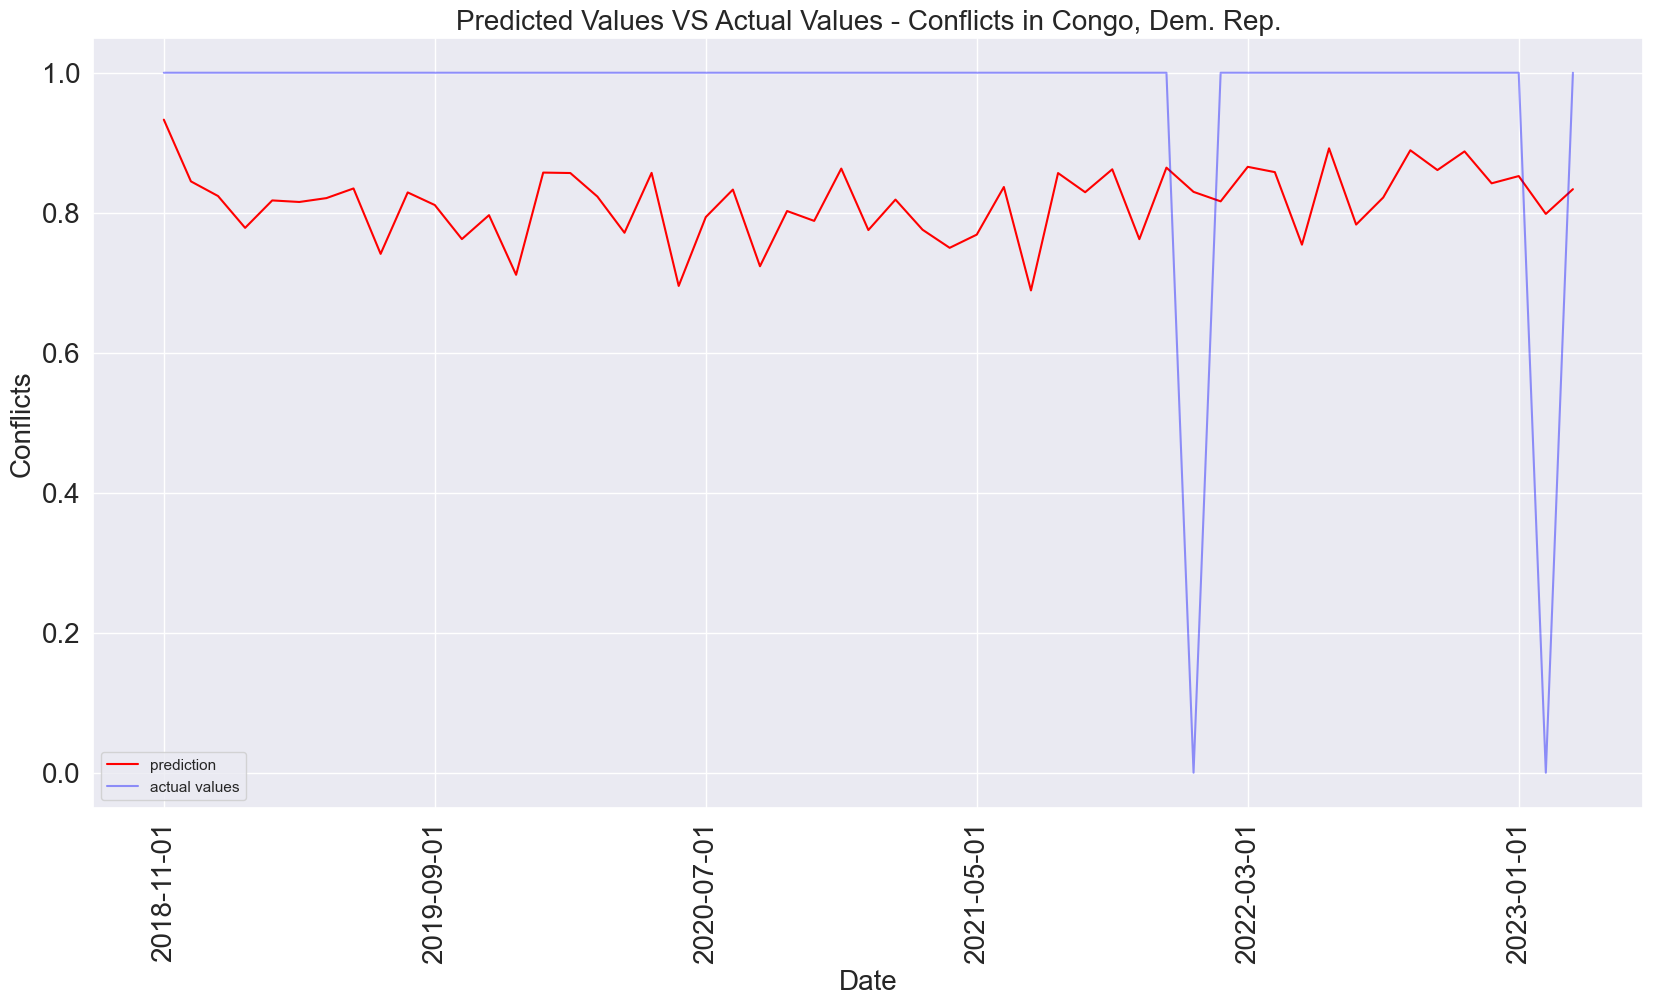

Epoch 1/30


2023-06-22 21:12:42.477255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:42.740120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:44.423913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 5s 534ms/step - loss: 0.3981 - accuracy: 0.6306 - recall_73: 0.4672
Epoch 2/30
5/5 [==============================] - 1s 194ms/step - loss: 0.2787 - accuracy: 0.5946 - recall_73: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 96ms/step - loss: 0.2607 - accuracy: 0.5495 - recall_73: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 88ms/step - loss: 0.2736 - accuracy: 0.5495 - recall_73: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 56ms/step - loss: 0.2774 - accuracy: 0.5495 - recall_73: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 17ms/step - loss: 0.2672 - accuracy: 0.5495 - recall_73: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 33ms/step - loss: 0.2521 - accuracy: 0.5495 - recall_73: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 51ms/step - loss: 0.2385 - accuracy: 0.5495 - recall_73: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 32ms/step - loss: 0.

2023-06-22 21:12:51.652737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:51.705344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 49ms/step
Central African Republic - Precision: 0.9433962264150944


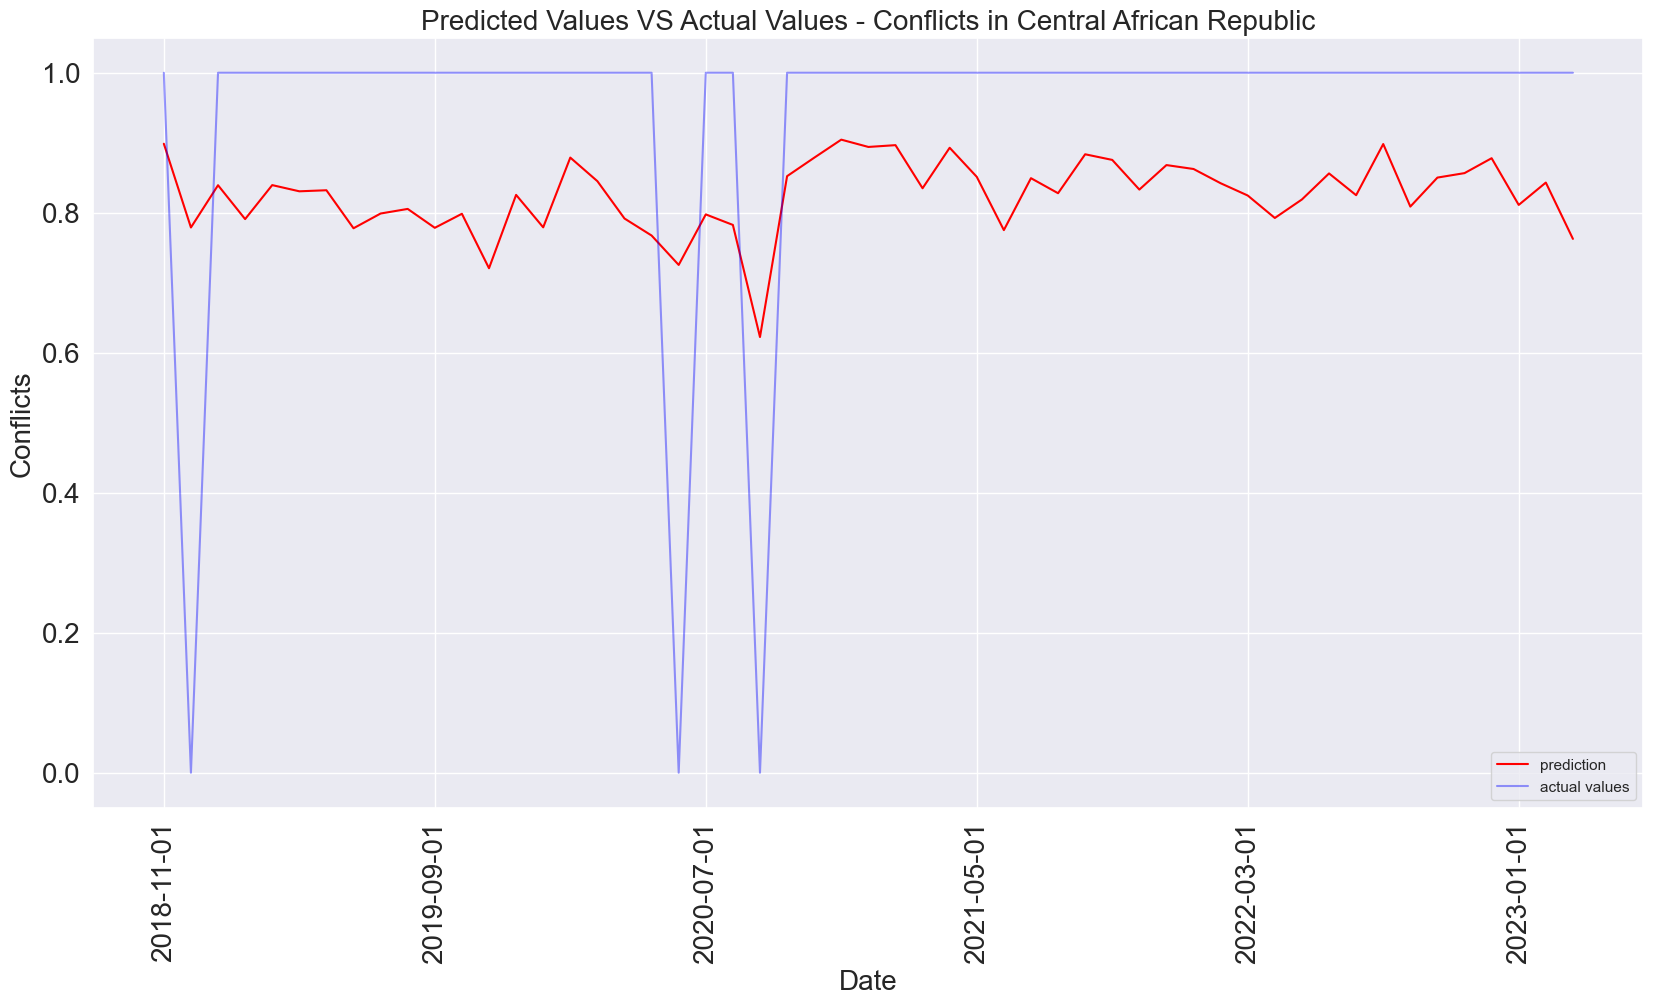

Epoch 1/30


2023-06-22 21:12:52.793239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:53.019707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:12:54.360356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 6s 719ms/step - loss: 0.3237 - accuracy: 0.5450 - recall_74: 0.5514
Epoch 2/30
5/5 [==============================] - 1s 142ms/step - loss: 0.2342 - accuracy: 0.4910 - recall_74: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 66ms/step - loss: 0.2414 - accuracy: 0.4820 - recall_74: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 78ms/step - loss: 0.2525 - accuracy: 0.4820 - recall_74: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 105ms/step - loss: 0.2389 - accuracy: 0.4820 - recall_74: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 24ms/step - loss: 0.2172 - accuracy: 0.4820 - recall_74: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 51ms/step - loss: 0.1996 - accuracy: 0.5270 - recall_74: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 38ms/step - loss: 0.1856 - accuracy: 0.6171 - recall_74: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 45ms/step - loss: 0

2023-06-22 21:13:02.641353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:02.693769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 101ms/step
Nigeria - Precision: 0.9056603773584906


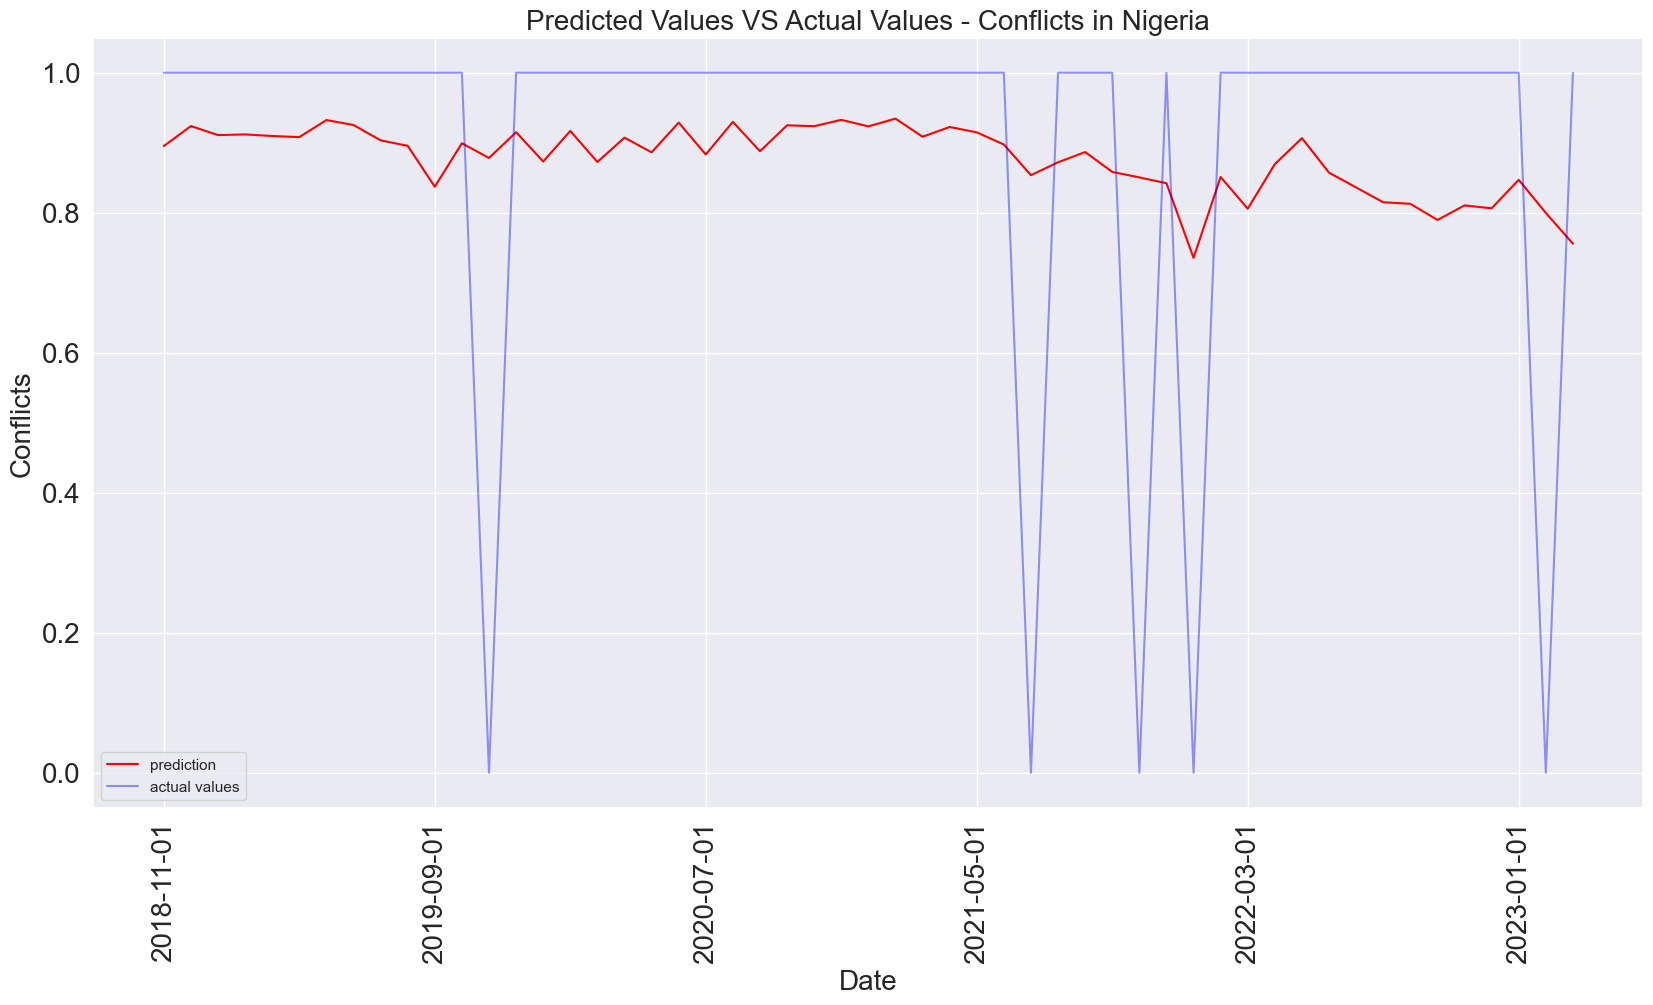

Epoch 1/30


2023-06-22 21:13:03.886561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:04.161328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:05.545584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 5s 472ms/step - loss: 0.4078 - accuracy: 0.5946 - recall_75: 0.9270
Epoch 2/30
5/5 [==============================] - 1s 218ms/step - loss: 0.2869 - accuracy: 0.6171 - recall_75: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 81ms/step - loss: 0.2635 - accuracy: 0.6171 - recall_75: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 88ms/step - loss: 0.2456 - accuracy: 0.6171 - recall_75: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 240ms/step - loss: 0.2342 - accuracy: 0.6171 - recall_75: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 65ms/step - loss: 0.2300 - accuracy: 0.6171 - recall_75: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 77ms/step - loss: 0.2270 - accuracy: 0.6171 - recall_75: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 14ms/step - loss: 0.2207 - accuracy: 0.6171 - recall_75: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 13ms/step - loss: 0

2023-06-22 21:13:13.719997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:13.774558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 48ms/step
Israel - Precision: 0.5454545454545454


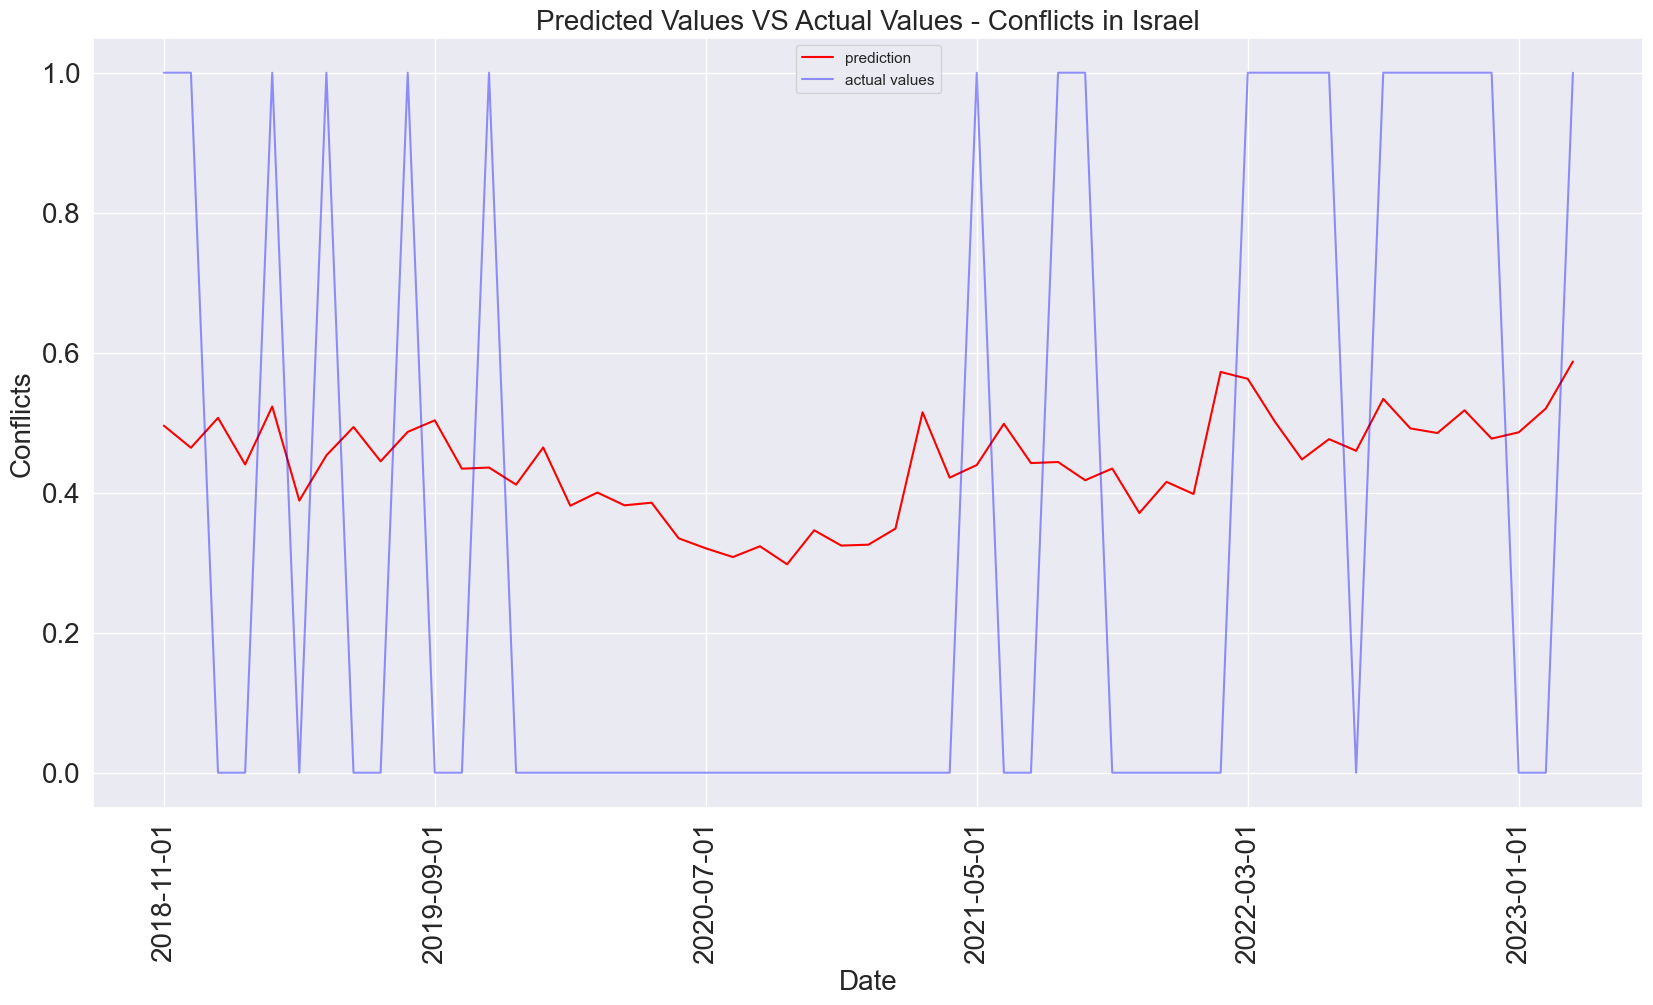

Epoch 1/30


2023-06-22 21:13:14.978921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:15.271114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:16.526742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 5s 557ms/step - loss: 0.3544 - accuracy: 0.5000 - recall_76: 0.0102
Epoch 2/30
5/5 [==============================] - 1s 182ms/step - loss: 0.2283 - accuracy: 0.8423 - recall_76: 0.9796
Epoch 3/30
5/5 [==============================] - 0s 59ms/step - loss: 0.1983 - accuracy: 0.4595 - recall_76: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 156ms/step - loss: 0.2046 - accuracy: 0.4414 - recall_76: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 25ms/step - loss: 0.2090 - accuracy: 0.4414 - recall_76: 1.0000 
Epoch 6/30
5/5 [==============================] - 0s 38ms/step - loss: 0.1999 - accuracy: 0.4414 - recall_76: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 39ms/step - loss: 0.1828 - accuracy: 0.4414 - recall_76: 1.0000 
Epoch 8/30
5/5 [==============================] - 0s 38ms/step - loss: 0.1652 - accuracy: 0.5225 - recall_76: 0.9898
Epoch 9/30
5/5 [==============================] - 0s 63ms/step - loss:

2023-06-22 21:13:24.146456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:24.201953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 47ms/step
Yemen, Rep. - Precision: 0.9811320754716981


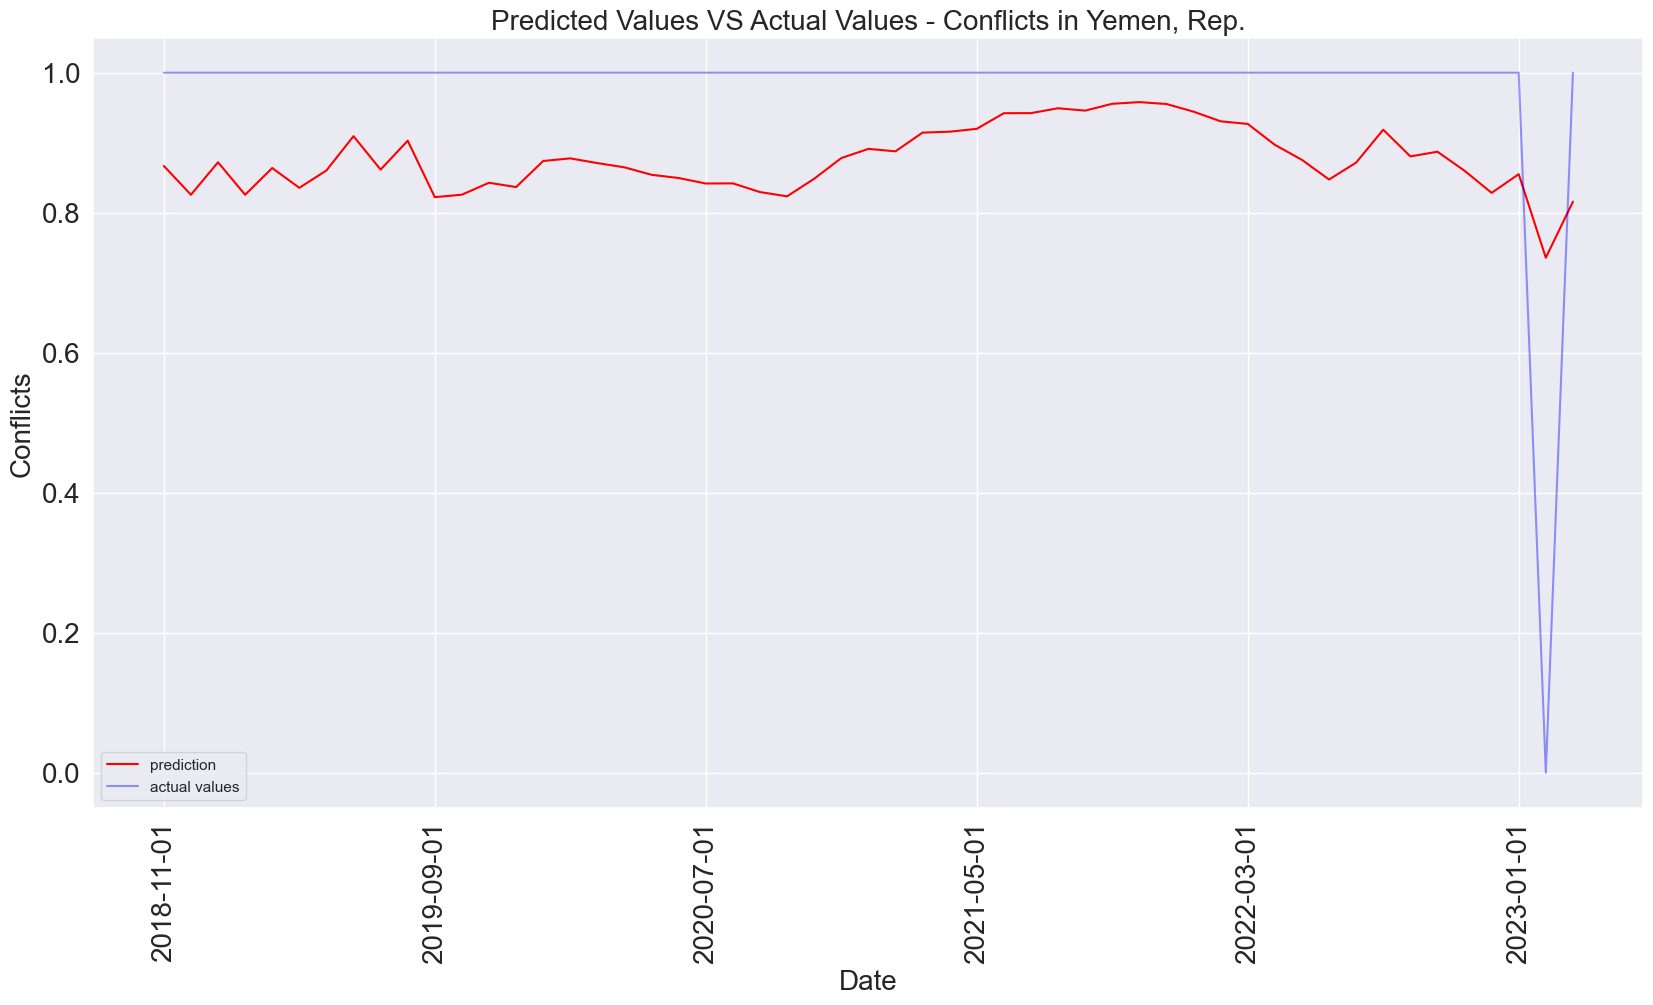

Epoch 1/30


2023-06-22 21:13:26.456680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:26.914741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:28.643789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 7s 611ms/step - loss: 0.3192 - accuracy: 0.5270 - recall_77: 0.0111
Epoch 2/30
5/5 [==============================] - 2s 316ms/step - loss: 0.1853 - accuracy: 0.9685 - recall_77: 0.9778
Epoch 3/30
5/5 [==============================] - 1s 173ms/step - loss: 0.1514 - accuracy: 0.5405 - recall_77: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 154ms/step - loss: 0.1487 - accuracy: 0.4324 - recall_77: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 89ms/step - loss: 0.1415 - accuracy: 0.4324 - recall_77: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 15ms/step - loss: 0.1224 - accuracy: 0.5766 - recall_77: 1.0000
Epoch 7/30
5/5 [==============================] - 0s 35ms/step - loss: 0.0988 - accuracy: 0.8559 - recall_77: 1.0000
Epoch 8/30
5/5 [==============================] - 0s 46ms/step - loss: 0.0778 - accuracy: 0.9640 - recall_77: 1.0000
Epoch 9/30
5/5 [==============================] - 0s 14ms/step - loss: 

2023-06-22 21:13:38.510465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:38.568452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 68ms/step
Syrian Arab Republic - Precision: 0.9622641509433962


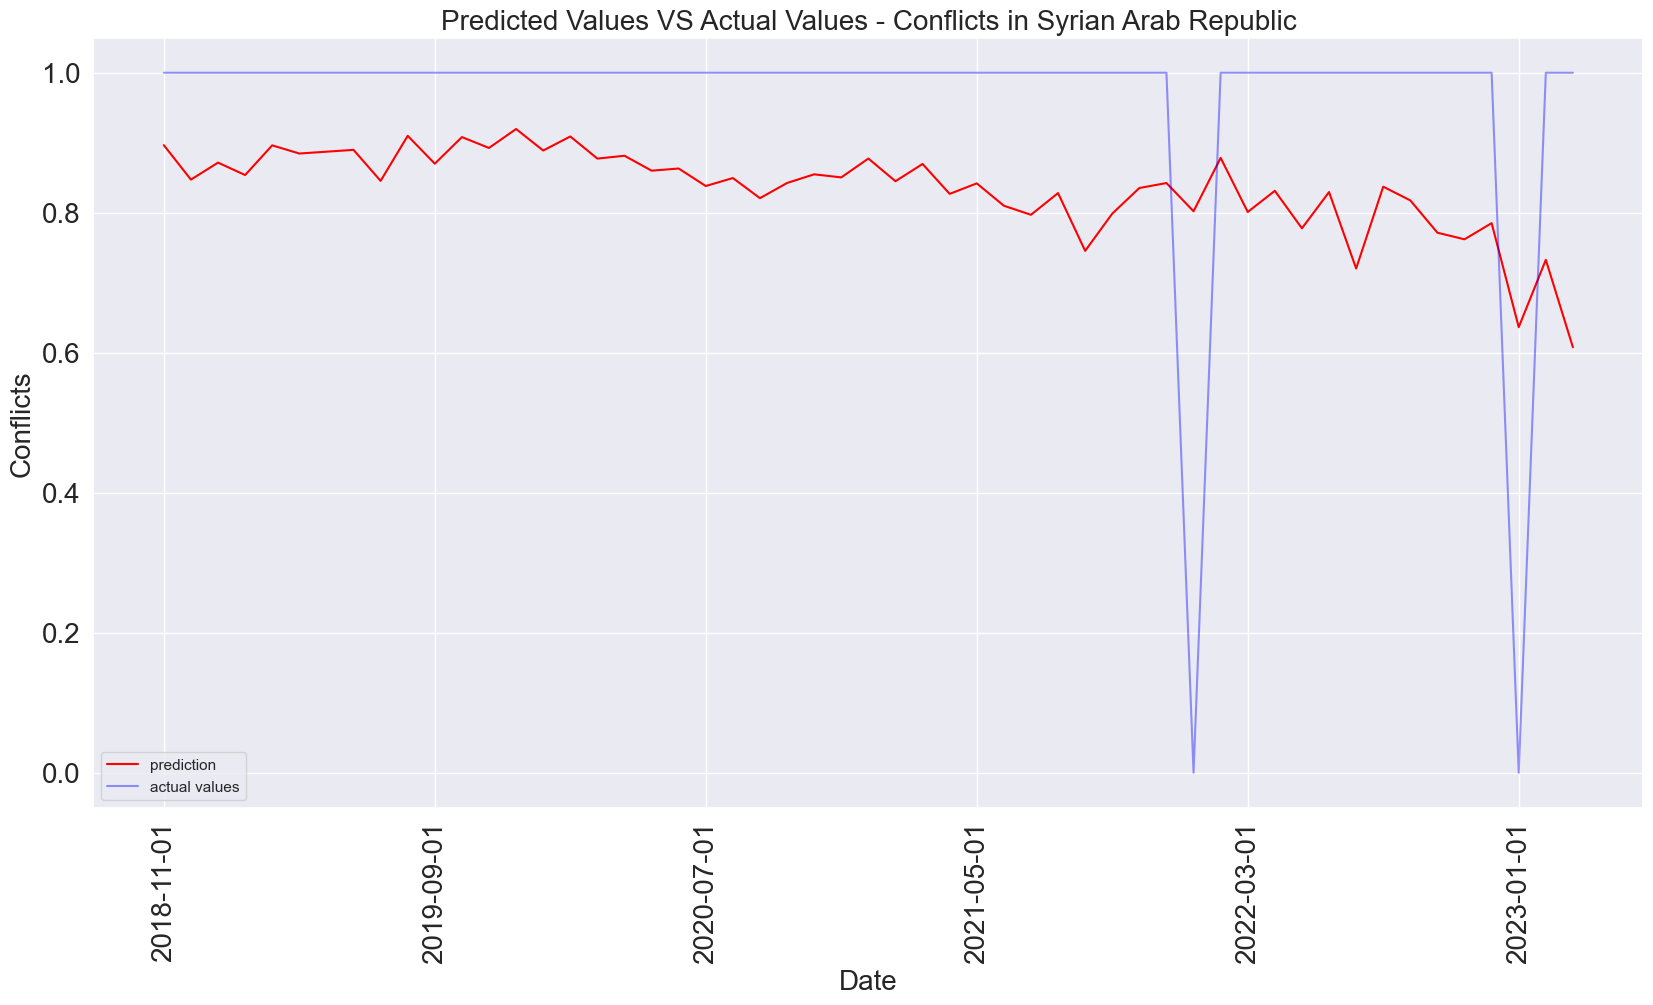

Epoch 1/30


2023-06-22 21:13:39.833807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:40.315852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:42.837274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 7s 847ms/step - loss: 0.2580 - accuracy: 0.5405 - recall_78: 0.3140
Epoch 2/30
5/5 [==============================] - 1s 203ms/step - loss: 0.2138 - accuracy: 0.5450 - recall_78: 0.9767
Epoch 3/30
5/5 [==============================] - 1s 188ms/step - loss: 0.2166 - accuracy: 0.3964 - recall_78: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 142ms/step - loss: 0.2116 - accuracy: 0.3964 - recall_78: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 69ms/step - loss: 0.2008 - accuracy: 0.5180 - recall_78: 1.0000
Epoch 6/30
5/5 [==============================] - 0s 58ms/step - loss: 0.1930 - accuracy: 0.6441 - recall_78: 0.9884
Epoch 7/30
5/5 [==============================] - 0s 15ms/step - loss: 0.1861 - accuracy: 0.6757 - recall_78: 0.9651
Epoch 8/30
5/5 [==============================] - 0s 36ms/step - loss: 0.1790 - accuracy: 0.6757 - recall_78: 0.9651
Epoch 9/30
5/5 [==============================] - 0s 69ms/step - loss: 

2023-06-22 21:13:52.244631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-22 21:13:52.297274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 90ms/step
Mexico - Precision: 1.0


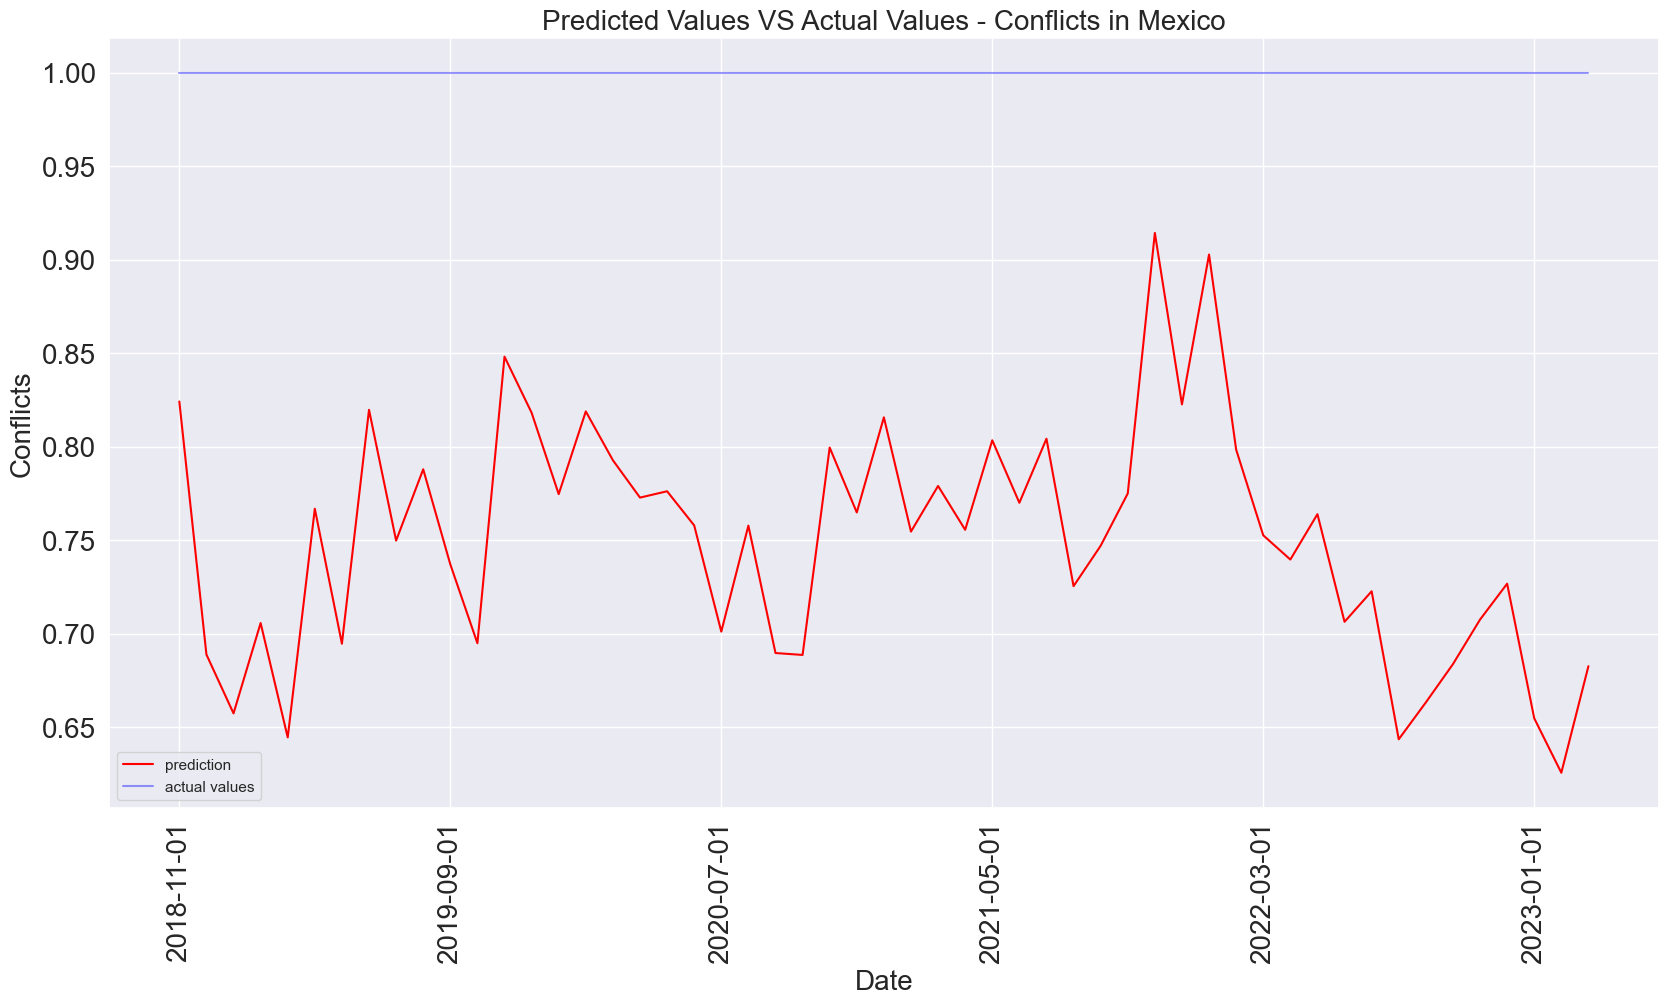

In [494]:
for i in range(len(top_10_country_names)): 
    # Obtain one country's data 
    country = armedconfdf[armedconfdf.country == top_10_country_names[i]]
        
    # Train test split, normalization and reshape the data
    x_train, x_test, y_train, y_test  = normalization_train_test_split(country)
    
    class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # Create dictionary mapping classes to their weights
    class_weight_dict = dict(enumerate(class_weights))

# design network for conflicts 
    model = Sequential()
    model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2])))  # Single LSTM layer with 60 neurons
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Output layer

    loss = BinaryFocalLoss(gamma=2., pos_weight=3)  # Increase gamma for more focus on hard to classify instances
    model.compile(loss=loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy', metrics.Recall()])

    # fit network with class weights for handling imbalance
    history = model.fit(x_train, y_train, epochs=30, batch_size=50, class_weight=class_weight_dict, verbose=1, shuffle=False)  
    # make a prediction
    y_test_pre = model.predict(x_test)

    precision = precision_score(y_test[:-2], [round(i[0]) for i in y_test_pre][2:])
    print('{} - Precision: {}'.format(top_10_country_names[i], precision))

# Create new dataframe for plot 
    pa=pd.DataFrame()
# Again note the adjustments here for the time-shift
    pa['Date']=list(country.month_year.iloc[int(len(country)*0.8):])[2:-2]
    pa['Prediction']=[i[0] for i in y_test_pre][2:] 
    pa['Actual Values']=list(y_test[:-2])
    plt.figure(figsize=(20,10))
    pa.groupby('Date')['Prediction'].sum().plot(kind='line', label='prediction', color='red', alpha=1)
    pa.groupby("Date")['Actual Values'].sum().plot(kind='line', label='actual values', color='blue', alpha=0.4)
    plt.xticks(rotation=90,size=20)
    plt.yticks(size=20)

    plt.ylabel('Conflicts',fontsize=20)
    plt.xlabel('Date',fontsize=20)
    plt.title('Predicted Values VS Actual Values - Conflicts in {}'.format(top_10_country_names[i]),fontsize=20)
    plt.legend()
    plt.show()
